#Packages loading

In [2]:
!pip install selfies

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
import selfies as sf
import functools
import random
import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import balanced_accuracy_score, roc_curve, roc_auc_score, matthews_corrcoef
from sklearn.metrics import confusion_matrix, classification_report, precision_score, recall_score, f1_score

import torch
import torch.nn as nn
from torch.nn import Parameter
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, SubsetRandomSampler
import torch.optim as optim

In [4]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

Saving AID_2302_datatable_all.csv to AID_2302_datatable_all.csv
User uploaded file "AID_2302_datatable_all.csv" with length 1417796 bytes


#Data loading & processing

In [5]:
df = pd.read_csv('AID_2302_datatable_all.csv')
df.head(10)

,PUBCHEM_RESULT_TAG,PUBCHEM_SID,PUBCHEM_CID,PUBCHEM_EXT_DATASOURCE_SMILES,PUBCHEM_ACTIVITY_OUTCOME,PUBCHEM_ACTIVITY_SCORE,PUBCHEM_ACTIVITY_URL,PUBCHEM_ASSAYDATA_COMMENT,PCT_INHIB_DD2
0,RESULT_TYPE,NaN,NaN,NaN,NaN,NaN,NaN,NaN,FLOAT
1,RESULT_DESCR,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Percent inhibition of P. falciparum Dd2 growth.
2,RESULT_UNIT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,PERCENT
3,RESULT_ATTR_CONC_MICROMOL,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2
4,1,85857918.0,11957475.0,C1CN(CCN1CC(C(C2=CC=CC=C2)C3=CC=CC=C3)O)C4=CC(...,Inactive,NaN,NaN,NaN,4
5,2,85857919.0,6618861.0,C1CN(CC=C1C2=CNC3=CC=CC=C32)CC4=CC=CC=C4,Active,NaN,NaN,NaN,80
6,3,85857920.0,21924871.0,C1=CC(=CC=C1C2=CC3=C(N2)C=C(C=C3)C(=N)N)C(=N)N.Cl,Active,NaN,NaN,NaN,99
7,4,85857921.0,1365597.0,C1=CC(=CC=C1C2=NC3=C(N2)C=C(C=C3)C4=CC5=C(C=C4...,Active,NaN,NaN,NaN,96
8,5,85857922.0,10115148.0,C1=CC(=CC=C1C2=NC3=C(N2)C=C(C=C3)C4=CC5=C(C=C4...,Active,NaN,NaN,NaN,99
9,6,85857923.0,2540886.0,C1=CC=NC(=C1)CCNC2=C3C=CC(=CC3=NC=C2)Cl,Active,NaN,NaN,NaN,72


After loading the data, we remove unnecessary columns (features) and remove duplicates of the SMILES string and NaN values.

In [6]:
# extract necessary information
cleaned_df = df.loc[4:, ['PUBCHEM_EXT_DATASOURCE_SMILES', 'PUBCHEM_ACTIVITY_OUTCOME']].reset_index(drop=True)
cleaned_df

,PUBCHEM_EXT_DATASOURCE_SMILES,PUBCHEM_ACTIVITY_OUTCOME
0,C1CN(CCN1CC(C(C2=CC=CC=C2)C3=CC=CC=C3)O)C4=CC(...,Inactive
1,C1CN(CC=C1C2=CNC3=CC=CC=C32)CC4=CC=CC=C4,Active
2,C1=CC(=CC=C1C2=CC3=C(N2)C=C(C=C3)C(=N)N)C(=N)N.Cl,Active
3,C1=CC(=CC=C1C2=NC3=C(N2)C=C(C=C3)C4=CC5=C(C=C4...,Active
4,C1=CC(=CC=C1C2=NC3=C(N2)C=C(C=C3)C4=CC5=C(C=C4...,Active
...,...,...
13528,CCCC(=O)C1=CN=C2C(=C1NC3=C(C=CC=C3C)C)C=CC=C2O...,Inactive
13529,CN(C)CCCOC1=CC=C(C=C1)C2=CSC(=N2)NC(=NCC3=CC=C...,Active
13530,C1=CC(=C(C=C1OC2=C(C=C(C=C2I)C[C@@H](C(=O)O)N)...,Inactive
13531,C1=CC(=C(C=C1OC2=C(C=C(C=C2I)C[C@@H](C(=O)O)N)...,Inactive


In [7]:
# remove duplicate of smiles strings
cleaned_df.drop_duplicates('PUBCHEM_EXT_DATASOURCE_SMILES', inplace=True)
cleaned_df.dropna(inplace=True)
cleaned_df

,PUBCHEM_EXT_DATASOURCE_SMILES,PUBCHEM_ACTIVITY_OUTCOME
0,C1CN(CCN1CC(C(C2=CC=CC=C2)C3=CC=CC=C3)O)C4=CC(...,Inactive
1,C1CN(CC=C1C2=CNC3=CC=CC=C32)CC4=CC=CC=C4,Active
2,C1=CC(=CC=C1C2=CC3=C(N2)C=C(C=C3)C(=N)N)C(=N)N.Cl,Active
3,C1=CC(=CC=C1C2=NC3=C(N2)C=C(C=C3)C4=CC5=C(C=C4...,Active
4,C1=CC(=CC=C1C2=NC3=C(N2)C=C(C=C3)C4=CC5=C(C=C4...,Active
...,...,...
13528,CCCC(=O)C1=CN=C2C(=C1NC3=C(C=CC=C3C)C)C=CC=C2O...,Inactive
13529,CN(C)CCCOC1=CC=C(C=C1)C2=CSC(=N2)NC(=NCC3=CC=C...,Active
13530,C1=CC(=C(C=C1OC2=C(C=C(C=C2I)C[C@@H](C(=O)O)N)...,Inactive
13531,C1=CC(=C(C=C1OC2=C(C=C(C=C2I)C[C@@H](C(=O)O)N)...,Inactive


By extracting SMILES columns and the activity columns, we conduct washing for SMILES representation to remove minor elements. Then, we create a new representation by converting SMILES to SELFIES to gain more information of a molecule's structure.

In the end, the visualization of the data helps us understand the calss distribution of the data.

####SMILES & SELFIES

In [8]:
smiles_lst = cleaned_df['PUBCHEM_EXT_DATASOURCE_SMILES'].tolist()
activity = cleaned_df['PUBCHEM_ACTIVITY_OUTCOME'].tolist()

cleaned_smiles = [sorted(smile.split('.'), key=lambda e: len(e), reverse=True)[0] for smile in smiles_lst] # washing SMILES

selfies_lst = [sf.encoder(smile) for smile in cleaned_smiles]
cleaned_selfies = [list(sf.split_selfies(selfie)) for selfie in selfies_lst]

labels = [1 if a=='Active' else 0 for a in activity]  # transfroms activity to binary

In [ ]:
print(f'SMILES dataset has {len(cleaned_smiles)} datapoints')
print(f'SELFIES dataset has {len(cleaned_selfies)} datapoints')

SMILES dataset has 13456 datapoints
SELFIES dataset has 13456 datapoints


####Label distribution

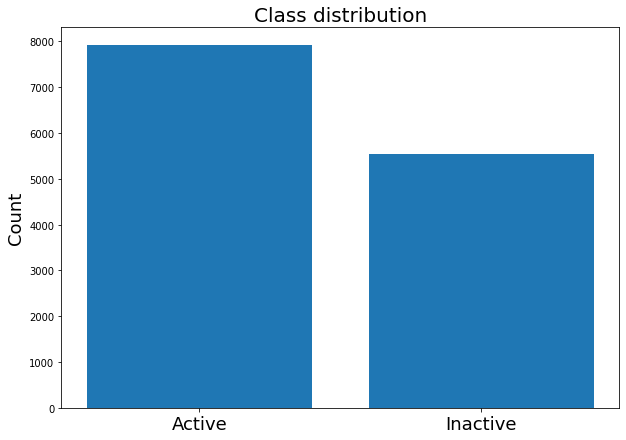

In [14]:
# visualize the contribution of activity
count = [len(np.where(np.array(labels)==1)[0]), len(np.where(np.array(labels)==0)[0])]

plt.figure(figsize = (10,7))
plt.bar(['Active', 'Inactive'], count)
plt.ylabel('Count', fontsize = 18)
plt.xticks(fontsize=18)
plt.title('Class distribution', fontsize = 20)
plt.show()

According to the visualization, we can see that there is a gap between class Active and class Inactive. Nevertheless, this is difference is still acceptable.

# Tokenization

Create a vocabulary for each representation

In [ ]:
def build_vocab(drug_str_lst: list) -> dict:
  vocab = {}
  for drug in drug_str_lst:
    for c in drug:
      if c not in vocab:
        vocab[c] = 1

  idx = 1
  for key, value in vocab.items():
    vocab[key] = idx
    idx += 1

  return vocab

In [ ]:
def tokenize(sample: str, vocab: dict) -> list:
  indices = []
  for word in sample:
    if word in vocab:
      indices.append(vocab[word])
  return indices

#Dataset construction

In [ ]:
class Dataset(Dataset):
  def __init__(self, drugs: list, labels: list, vocab: dict):
    self.drugs = drugs
    self.labels = labels
    self.vocab = vocab
    self.max_length = len(max(drugs, key=lambda e: len(e)))

  def __getitem__(self, idx: int):
    sample = tokenize(self.drugs[idx], self.vocab)

    # conduct padding in here, to ensure each sample's length is same
    while len(sample) < self.max_length:
      sample.append(0)
    
    length = len(sample)
    return {'drug': sample, 'length': length, 'label': float(self.labels[idx])}

  def __len__(self):
    return len(self.drugs)


def collate(batch, pad_index):
  drug = [torch.LongTensor(i['drug']) for i in batch]
  drug = nn.utils.rnn.pad_sequence(drug, padding_value=pad_index, batch_first=True)
  length = [i['length'] for i in batch]
  label = torch.LongTensor([i['label'] for i in batch])
  batch = {'drug': drug, 'length': length, 'label': label}
  return batch

collate_fn = collate

#Model construction

In [ ]:
device = 'cuda' if torch.cuda.is_available else 'cpu'
device

####Attentation mechanism

In [ ]:
# # attention mechanism
# class Attention(nn.Module):
#   def __init__(self, num_features, kvdim):
#     super(Attention, self).__init__()
#     self.num_features = num_features
#     self.kv_dim = kvdim

#     self.q_w = nn.Linear(self.num_features, self.kv_dim)
#     self.k_w = nn.Linear(self.num_features, self.kv_dim)
#     self.v_w = nn.Linear(self.num_features, self.kv_dim)
#     self.softmax = nn.Softmax(dim=-1)

#   def forward(self, x):
#     Q = self.q_w(x)
#     K = self.k_w(x)
#     V = self.v_w(x)

#     score = torch.bmm(Q, torch.transpose(K, 1, 2)) / np.sqrt(self.kv_dim)
#     atten_prob = self.softmax(score)
#     atten_score = atten_prob @ V
#     return atten_score

#### GRU model

In [ ]:
def init_weights(m):
    if isinstance(m, nn.Linear):
        nn.init.xavier_normal_(m.weight)
        nn.init.zeros_(m.bias)
    elif isinstance(m, nn.GRU):
        for name, param in m.named_parameters():
            if 'bias' in name:
                nn.init.zeros_(param)
            elif 'weight' in name:
                nn.init.orthogonal_(param)


class GRU(nn.Module):
  def __init__(self, 
               input_dim: int,
               hidden_dim: int,
               output_dim: int,
               n_layers: int,
               dropout_rate: float,
               bidirectional: bool=False, 
               **kwargs):
    super(GRU, self).__init__()
    self.n_directions = 2 if bidirectional else 1
    self.bidirectional = bidirectional
    self.embedding = nn.Embedding(input_dim+1, hidden_dim)
    self.GRU = nn.GRU(hidden_dim,
                      hidden_dim,
                      n_layers,
                      bidirectional=bidirectional,
                      batch_first=True,
                      dropout=dropout_rate)
    self.fc = nn.Linear(hidden_dim * self.n_directions, output_dim)
    self.dropout = nn.Dropout(dropout_rate)

    # weight initialization
    if "weight_init_fn" not in kwargs:
      self.apply(init_weights)
    else:
      self.apply(kwargs["weight_init_fn"])

  def forward(self, x, length):
    x = self.embedding(x)
    x = nn.utils.rnn.pack_padded_sequence(x, length, batch_first=True, enforce_sorted=False)
    out, hn = self.GRU(x)
    if self.bidirectional:
      out = torch.cat([hn[-1], hn[-2]], dim=1)
    else:
      out = hn[-1]
    prediction = self.fc(out)
    return prediction

#Training & Testing

####Training & evaluate function

In [ ]:
def training(model, dataloader, criterion, optimizer, scheduler, device):
  torch.manual_seed(0)
  random.seed(0)
  np.random.seed(0)

  model.train()
  train_acc = []
  train_losses = []
  
  for batch in tqdm.tqdm(dataloader, desc='Training...'):
    x = batch['drug'].to(device)
    length = batch['length']
    y = batch['label'].to(device)

    predictions = model(x, length)

    # forward propagation
    loss = criterion(predictions, y)
    accuracy = get_accuracy(predictions, y)
    train_losses.append(loss.item())
    train_acc.append(accuracy.item())

    # backward propagation
    optimizer.zero_grad()
    loss.requires_grad_(True)
    loss.backward()
    optimizer.step()
    scheduler.step()
  return train_acc, train_losses, predictions


def get_accuracy(prediction, label):
  batch_size, _ = prediction.shape
  predicted_classes = prediction.argmax(dim=-1)
  correct_predictions = predicted_classes.eq(label).sum()
  accuracy = correct_predictions / batch_size
  return accuracy


def evaluate(model, dataloader, criterion, device):
  model.eval()
  eval_acc = []
  eval_losses = []
  eval_preds = []

  with torch.no_grad():
    for batch in tqdm.tqdm(dataloader, desc='Evaluating...'):
      x = batch['drug'].to(device)
      length = batch['length']
      y = batch['label'].to(device)

      predictions = model(x, length)
      eval_preds.append(predictions)

      loss = criterion(predictions, y)
      accuracy = get_accuracy(predictions, y)
      eval_losses.append(loss.item())
      eval_acc.append(accuracy.item())
  return eval_acc, eval_losses, eval_preds

In [ ]:
class ConstantWithWarmup(torch.optim.lr_scheduler._LRScheduler):
    def __init__(
        self,
        optimizer,
        num_warmup_steps: int,
    ):
        self.num_warmup_steps = num_warmup_steps
        super().__init__(optimizer)

    def get_lr(self):
        if self._step_count <= self.num_warmup_steps:
            # warmup
            scale = 1.0 - (self.num_warmup_steps - self._step_count) / self.num_warmup_steps
            lr = [base_lr * scale for base_lr in self.base_lrs]
            self.last_lr = lr
        else:
            lr = self.base_lrs
        return lr

####Cross validation function

In [ ]:
def reset_model(m):
  if isinstance(m, nn.GRU) or isinstance(m, nn.Linear):
    m.reset_parameters()


def cross_valid(dataset,
                model, 
                criterion, 
                optimizer,
                scheduler,
                splitter,
                ):
  history_lst = []
  for idx, (train_idx, val_idx) in enumerate(splitter.split(np.arange(len(dataset)))):
    print(f'Fold {idx+1}:')
    # convert to dataloader for each fold
    train_sampler = SubsetRandomSampler(train_idx)
    test_sampler = SubsetRandomSampler(val_idx)
    train_dataloader = DataLoader(dataset, batch_size=BATCH, sampler=train_sampler, collate_fn=collate)
    test_dataloader = DataLoader(dataset, batch_size=BATCH, sampler=test_sampler, collate_fn=collate)

    # record each fold's result
    history = {'train_loss': [], 'train_acc': [], 'test_loss': [], 'test_acc': []}
    fold_train_losses, fold_train_accs = [], []
    fold_test_losses, fold_test_accs = [], []

    for e in range(EPOCHS):
      print(f'Epoch {e+1}:')
      # The collection of accuracy and loss for batches
      batch_train_accs, batch_train_losses, batch_train_predictions = training(model, 
                                                                               train_dataloader, 
                                                                               criterion, 
                                                                               optimizer, 
                                                                               scheduler, 
                                                                               device)
      
      # the average loss and accuracy of an epoch
      epoch_train_acc = np.mean(batch_train_accs)
      epoch_train_loss = np.mean(batch_train_losses)
      fold_train_accs.append(epoch_train_acc)
      fold_train_losses.append(epoch_train_loss)
      print(f'Training loss: {round(epoch_train_loss, 4)}; Training acc: {round(epoch_train_acc, 4)}')

    batch_test_accs, batch_test_losses, batch_test_predictions = evaluate(model, 
                                                                          test_dataloader,
                                                                          criterion,
                                                                          device)
    epoch_test_acc = np.mean(batch_test_accs)
    epoch_test_loss = np.mean(batch_test_losses)
    fold_test_accs.append(epoch_test_acc)
    fold_test_losses.append(epoch_test_loss)
    print(f'Test loss: {round(epoch_test_loss, 4)}; Test acc: {round(epoch_test_acc, 4)}')

    # the average of loss and accuracy of one fold
    history['train_acc'].append(np.mean(fold_train_accs))
    history['train_loss'].append(np.mean(fold_train_losses))
    history['test_acc'].append(np.mean(fold_test_accs))
    history['test_loss'].append(np.mean(fold_test_losses))

    print(f'AVG training loss: {round(np.mean(fold_train_losses), 4)};\
    AVG training acc: {round(np.mean(fold_train_accs), 4)}')
    print(f'AVG test loss: {round(np.mean(fold_test_losses), 4)};\
    AVG test acc: {round(np.mean(fold_test_accs), 4)}')
    history_lst.append(history)

    model.apply(reset_model)
    torch.cuda.empty_cache()

  return history_lst

####Start to train and test the model

In [ ]:
smiles_vocab = build_vocab(cleaned_smiles)
selfies_vocab = build_vocab(cleaned_selfies)

smiles_dataset = Dataset(cleaned_smiles, labels, smiles_vocab)
selfies_dataset = Dataset(cleaned_selfies, labels, selfies_vocab)

#####SMILES dataset

In [ ]:
# hyperparameter constants
SPLIT = 10

HIDDEN = 256
N_LAYERS = 4
DROPOUT = 0.6
PAD_IDX = 0

BATCH = 256 # each dataset has 13,456 datapoints
LR = 5e-4
DECAY = 1e-5
WARMUP_STEPS = 200
EPOCHS = 30

splitter = KFold(n_splits=SPLIT, shuffle=True, random_state=0)
collate = functools.partial(collate_fn, pad_index=PAD_IDX)

model = GRU(len(smiles_vocab), 
            hidden_dim=HIDDEN, 
            output_dim=2, 
            n_layers=N_LAYERS, 
            dropout_rate=DROPOUT,
            bidirectional=False).to(device)
criterion = nn.CrossEntropyLoss().to(device)
optimizer = optim.Adam(model.parameters(), lr=LR, weight_decay=DECAY, eps=1e-6)
scheduler = ConstantWithWarmup(optimizer, WARMUP_STEPS)

smiles_history = cross_valid(smiles_dataset,
                             model,
                             criterion,
                             optimizer,
                             scheduler,
                             splitter)

Fold 1:
Epoch 1:


Training...: 100%|██████████| 48/48 [00:07<00:00,  6.62it/s]


Training loss: 0.6826; Training acc: 0.5808
Epoch 2:


Training...: 100%|██████████| 48/48 [00:06<00:00,  7.68it/s]


Training loss: 0.6845; Training acc: 0.5779
Epoch 3:


Training...: 100%|██████████| 48/48 [00:06<00:00,  7.58it/s]


Training loss: 0.681; Training acc: 0.5878
Epoch 4:


Training...: 100%|██████████| 48/48 [00:06<00:00,  7.41it/s]


Training loss: 0.68; Training acc: 0.5846
Epoch 5:


Training...: 100%|██████████| 48/48 [00:07<00:00,  6.46it/s]


Training loss: 0.681; Training acc: 0.5807
Epoch 6:


Training...: 100%|██████████| 48/48 [00:06<00:00,  7.12it/s]


Training loss: 0.6771; Training acc: 0.5859
Epoch 7:


Training...: 100%|██████████| 48/48 [00:06<00:00,  7.47it/s]


Training loss: 0.6736; Training acc: 0.5843
Epoch 8:


Training...: 100%|██████████| 48/48 [00:06<00:00,  7.39it/s]


Training loss: 0.6648; Training acc: 0.5973
Epoch 9:


Training...: 100%|██████████| 48/48 [00:06<00:00,  7.33it/s]


Training loss: 0.6593; Training acc: 0.6045
Epoch 10:


Training...: 100%|██████████| 48/48 [00:06<00:00,  7.28it/s]


Training loss: 0.6504; Training acc: 0.6159
Epoch 11:


Training...: 100%|██████████| 48/48 [00:06<00:00,  7.24it/s]


Training loss: 0.6348; Training acc: 0.6441
Epoch 12:


Training...: 100%|██████████| 48/48 [00:06<00:00,  7.22it/s]


Training loss: 0.6261; Training acc: 0.6605
Epoch 13:


Training...: 100%|██████████| 48/48 [00:06<00:00,  7.17it/s]


Training loss: 0.6161; Training acc: 0.67
Epoch 14:


Training...: 100%|██████████| 48/48 [00:06<00:00,  6.92it/s]


Training loss: 0.5994; Training acc: 0.6868
Epoch 15:


Training...: 100%|██████████| 48/48 [00:06<00:00,  7.07it/s]


Training loss: 0.5911; Training acc: 0.6944
Epoch 16:


Training...: 100%|██████████| 48/48 [00:07<00:00,  6.83it/s]


Training loss: 0.5761; Training acc: 0.708
Epoch 17:


Training...: 100%|██████████| 48/48 [00:06<00:00,  6.93it/s]


Training loss: 0.5618; Training acc: 0.7204
Epoch 18:


Training...: 100%|██████████| 48/48 [00:06<00:00,  6.99it/s]


Training loss: 0.5498; Training acc: 0.7323
Epoch 19:


Training...: 100%|██████████| 48/48 [00:06<00:00,  6.97it/s]


Training loss: 0.5358; Training acc: 0.7433
Epoch 20:


Training...: 100%|██████████| 48/48 [00:06<00:00,  7.06it/s]


Training loss: 0.5243; Training acc: 0.7557
Epoch 21:


Training...: 100%|██████████| 48/48 [00:06<00:00,  7.06it/s]


Training loss: 0.5112; Training acc: 0.7637
Epoch 22:


Training...: 100%|██████████| 48/48 [00:06<00:00,  7.08it/s]


Training loss: 0.5023; Training acc: 0.7729
Epoch 23:


Training...: 100%|██████████| 48/48 [00:06<00:00,  7.07it/s]


Training loss: 0.5122; Training acc: 0.766
Epoch 24:


Training...: 100%|██████████| 48/48 [00:06<00:00,  6.87it/s]


Training loss: 0.5181; Training acc: 0.7646
Epoch 25:


Training...: 100%|██████████| 48/48 [00:06<00:00,  7.07it/s]


Training loss: 0.5052; Training acc: 0.7709
Epoch 26:


Training...: 100%|██████████| 48/48 [00:06<00:00,  6.98it/s]


Training loss: 0.4872; Training acc: 0.7841
Epoch 27:


Training...: 100%|██████████| 48/48 [00:06<00:00,  7.03it/s]


Training loss: 0.474; Training acc: 0.7889
Epoch 28:


Training...: 100%|██████████| 48/48 [00:06<00:00,  7.02it/s]


Training loss: 0.4644; Training acc: 0.7974
Epoch 29:


Training...: 100%|██████████| 48/48 [00:06<00:00,  6.98it/s]


Training loss: 0.4537; Training acc: 0.8021
Epoch 30:


Training...: 100%|██████████| 48/48 [00:06<00:00,  6.95it/s]


Training loss: 0.4421; Training acc: 0.8093


Evaluating...: 100%|██████████| 6/6 [00:00<00:00, 24.56it/s]


Test loss: 0.6543; Test acc: 0.717
AVG training loss: 0.5807;    AVG training acc: 0.6912
AVG test loss: 0.6543;    AVG test acc: 0.717
Fold 2:
Epoch 1:


Training...: 100%|██████████| 48/48 [00:06<00:00,  7.02it/s]


Training loss: 0.681; Training acc: 0.5886
Epoch 2:


Training...: 100%|██████████| 48/48 [00:06<00:00,  7.07it/s]


Training loss: 0.6797; Training acc: 0.5887
Epoch 3:


Training...: 100%|██████████| 48/48 [00:07<00:00,  6.86it/s]


Training loss: 0.6793; Training acc: 0.5889
Epoch 4:


Training...: 100%|██████████| 48/48 [00:06<00:00,  7.01it/s]


Training loss: 0.6793; Training acc: 0.589
Epoch 5:


Training...: 100%|██████████| 48/48 [00:06<00:00,  7.04it/s]


Training loss: 0.6786; Training acc: 0.5891
Epoch 6:


Training...: 100%|██████████| 48/48 [00:06<00:00,  7.07it/s]


Training loss: 0.6785; Training acc: 0.5889
Epoch 7:


Training...: 100%|██████████| 48/48 [00:06<00:00,  7.05it/s]


Training loss: 0.6786; Training acc: 0.589
Epoch 8:


Training...: 100%|██████████| 48/48 [00:06<00:00,  7.03it/s]


Training loss: 0.6784; Training acc: 0.589
Epoch 9:


Training...: 100%|██████████| 48/48 [00:06<00:00,  7.07it/s]


Training loss: 0.6778; Training acc: 0.589
Epoch 10:


Training...: 100%|██████████| 48/48 [00:06<00:00,  7.06it/s]


Training loss: 0.6782; Training acc: 0.589
Epoch 11:


Training...: 100%|██████████| 48/48 [00:06<00:00,  7.08it/s]


Training loss: 0.6779; Training acc: 0.589
Epoch 12:


Training...: 100%|██████████| 48/48 [00:06<00:00,  7.03it/s]


Training loss: 0.6786; Training acc: 0.589
Epoch 13:


Training...: 100%|██████████| 48/48 [00:07<00:00,  6.84it/s]


Training loss: 0.678; Training acc: 0.589
Epoch 14:


Training...: 100%|██████████| 48/48 [00:06<00:00,  7.01it/s]


Training loss: 0.6781; Training acc: 0.589
Epoch 15:


Training...: 100%|██████████| 48/48 [00:06<00:00,  7.03it/s]


Training loss: 0.6778; Training acc: 0.589
Epoch 16:


Training...: 100%|██████████| 48/48 [00:06<00:00,  7.00it/s]


Training loss: 0.6775; Training acc: 0.589
Epoch 17:


Training...: 100%|██████████| 48/48 [00:06<00:00,  6.98it/s]


Training loss: 0.678; Training acc: 0.589
Epoch 18:


Training...: 100%|██████████| 48/48 [00:06<00:00,  6.98it/s]


Training loss: 0.6777; Training acc: 0.589
Epoch 19:


Training...: 100%|██████████| 48/48 [00:06<00:00,  7.03it/s]


Training loss: 0.6779; Training acc: 0.589
Epoch 20:


Training...: 100%|██████████| 48/48 [00:06<00:00,  7.00it/s]


Training loss: 0.6779; Training acc: 0.589
Epoch 21:


Training...: 100%|██████████| 48/48 [00:06<00:00,  7.02it/s]


Training loss: 0.678; Training acc: 0.589
Epoch 22:


Training...: 100%|██████████| 48/48 [00:07<00:00,  6.69it/s]


Training loss: 0.678; Training acc: 0.589
Epoch 23:


Training...: 100%|██████████| 48/48 [00:06<00:00,  6.94it/s]


Training loss: 0.6775; Training acc: 0.589
Epoch 24:


Training...: 100%|██████████| 48/48 [00:06<00:00,  7.05it/s]


Training loss: 0.6778; Training acc: 0.589
Epoch 25:


Training...: 100%|██████████| 48/48 [00:06<00:00,  7.00it/s]


Training loss: 0.6778; Training acc: 0.589
Epoch 26:


Training...: 100%|██████████| 48/48 [00:06<00:00,  6.95it/s]


Training loss: 0.6776; Training acc: 0.589
Epoch 27:


Training...: 100%|██████████| 48/48 [00:06<00:00,  7.01it/s]


Training loss: 0.6778; Training acc: 0.589
Epoch 28:


Training...: 100%|██████████| 48/48 [00:06<00:00,  7.02it/s]


Training loss: 0.6778; Training acc: 0.589
Epoch 29:


Training...: 100%|██████████| 48/48 [00:06<00:00,  7.00it/s]


Training loss: 0.6778; Training acc: 0.589
Epoch 30:


Training...: 100%|██████████| 48/48 [00:07<00:00,  6.83it/s]


Training loss: 0.6776; Training acc: 0.589


Evaluating...: 100%|██████████| 6/6 [00:00<00:00, 25.09it/s]


Test loss: 0.6797; Test acc: 0.5823
AVG training loss: 0.6782;    AVG training acc: 0.589
AVG test loss: 0.6797;    AVG test acc: 0.5823
Fold 3:
Epoch 1:


Training...: 100%|██████████| 48/48 [00:06<00:00,  6.99it/s]


Training loss: 0.6833; Training acc: 0.58
Epoch 2:


Training...: 100%|██████████| 48/48 [00:06<00:00,  7.00it/s]


Training loss: 0.6807; Training acc: 0.5867
Epoch 3:


Training...: 100%|██████████| 48/48 [00:06<00:00,  7.01it/s]


Training loss: 0.6806; Training acc: 0.5867
Epoch 4:


Training...: 100%|██████████| 48/48 [00:06<00:00,  7.04it/s]


Training loss: 0.6801; Training acc: 0.5869
Epoch 5:


Training...: 100%|██████████| 48/48 [00:06<00:00,  7.00it/s]


Training loss: 0.6799; Training acc: 0.5869
Epoch 6:


Training...: 100%|██████████| 48/48 [00:06<00:00,  7.00it/s]


Training loss: 0.6801; Training acc: 0.5867
Epoch 7:


Training...: 100%|██████████| 48/48 [00:06<00:00,  7.02it/s]


Training loss: 0.6797; Training acc: 0.5869
Epoch 8:


Training...: 100%|██████████| 48/48 [00:06<00:00,  6.99it/s]


Training loss: 0.6792; Training acc: 0.5869
Epoch 9:


Training...: 100%|██████████| 48/48 [00:06<00:00,  6.98it/s]


Training loss: 0.6791; Training acc: 0.5869
Epoch 10:


Training...: 100%|██████████| 48/48 [00:06<00:00,  6.99it/s]


Training loss: 0.6794; Training acc: 0.5869
Epoch 11:


Training...: 100%|██████████| 48/48 [00:07<00:00,  6.82it/s]


Training loss: 0.6787; Training acc: 0.5869
Epoch 12:


Training...: 100%|██████████| 48/48 [00:06<00:00,  7.01it/s]


Training loss: 0.6785; Training acc: 0.5869
Epoch 13:


Training...: 100%|██████████| 48/48 [00:06<00:00,  7.00it/s]


Training loss: 0.6787; Training acc: 0.5869
Epoch 14:


Training...: 100%|██████████| 48/48 [00:06<00:00,  7.03it/s]


Training loss: 0.6784; Training acc: 0.5869
Epoch 15:


Training...: 100%|██████████| 48/48 [00:06<00:00,  6.98it/s]


Training loss: 0.6789; Training acc: 0.5869
Epoch 16:


Training...: 100%|██████████| 48/48 [00:06<00:00,  7.02it/s]


Training loss: 0.6792; Training acc: 0.5869
Epoch 17:


Training...: 100%|██████████| 48/48 [00:06<00:00,  7.05it/s]


Training loss: 0.6788; Training acc: 0.5869
Epoch 18:


Training...: 100%|██████████| 48/48 [00:06<00:00,  7.00it/s]


Training loss: 0.6786; Training acc: 0.5869
Epoch 19:


Training...: 100%|██████████| 48/48 [00:06<00:00,  7.00it/s]


Training loss: 0.6783; Training acc: 0.5869
Epoch 20:


Training...: 100%|██████████| 48/48 [00:07<00:00,  6.85it/s]


Training loss: 0.6787; Training acc: 0.5869
Epoch 21:


Training...: 100%|██████████| 48/48 [00:06<00:00,  7.03it/s]


Training loss: 0.6783; Training acc: 0.5869
Epoch 22:


Training...: 100%|██████████| 48/48 [00:06<00:00,  6.99it/s]


Training loss: 0.6784; Training acc: 0.5869
Epoch 23:


Training...: 100%|██████████| 48/48 [00:06<00:00,  7.03it/s]


Training loss: 0.6783; Training acc: 0.5869
Epoch 24:


Training...: 100%|██████████| 48/48 [00:06<00:00,  7.05it/s]


Training loss: 0.6782; Training acc: 0.5869
Epoch 25:


Training...: 100%|██████████| 48/48 [00:06<00:00,  7.03it/s]


Training loss: 0.6785; Training acc: 0.5869
Epoch 26:


Training...: 100%|██████████| 48/48 [00:06<00:00,  7.02it/s]


Training loss: 0.6784; Training acc: 0.5869
Epoch 27:


Training...: 100%|██████████| 48/48 [00:06<00:00,  7.01it/s]


Training loss: 0.6785; Training acc: 0.5869
Epoch 28:


Training...: 100%|██████████| 48/48 [00:06<00:00,  7.03it/s]


Training loss: 0.6782; Training acc: 0.5869
Epoch 29:


Training...: 100%|██████████| 48/48 [00:07<00:00,  6.66it/s]


Training loss: 0.6783; Training acc: 0.5869
Epoch 30:


Training...: 100%|██████████| 48/48 [00:06<00:00,  6.98it/s]


Training loss: 0.6785; Training acc: 0.5869


Evaluating...: 100%|██████████| 6/6 [00:00<00:00, 24.62it/s]


Test loss: 0.6762; Test acc: 0.5942
AVG training loss: 0.6791;    AVG training acc: 0.5866
AVG test loss: 0.6762;    AVG test acc: 0.5942
Fold 4:
Epoch 1:


Training...: 100%|██████████| 48/48 [00:06<00:00,  7.02it/s]


Training loss: 0.6831; Training acc: 0.5823
Epoch 2:


Training...: 100%|██████████| 48/48 [00:06<00:00,  7.00it/s]


Training loss: 0.6811; Training acc: 0.5818
Epoch 3:


Training...: 100%|██████████| 48/48 [00:07<00:00,  6.39it/s]


Training loss: 0.682; Training acc: 0.5856
Epoch 4:


Training...: 100%|██████████| 48/48 [00:07<00:00,  6.47it/s]


Training loss: 0.6804; Training acc: 0.5872
Epoch 5:


Training...: 100%|██████████| 48/48 [00:06<00:00,  6.98it/s]


Training loss: 0.6801; Training acc: 0.5874
Epoch 6:


Training...: 100%|██████████| 48/48 [00:07<00:00,  6.59it/s]


Training loss: 0.6788; Training acc: 0.5873
Epoch 7:


Training...: 100%|██████████| 48/48 [00:06<00:00,  7.01it/s]


Training loss: 0.6794; Training acc: 0.5873
Epoch 8:


Training...: 100%|██████████| 48/48 [00:07<00:00,  6.82it/s]


Training loss: 0.679; Training acc: 0.5873
Epoch 9:


Training...: 100%|██████████| 48/48 [00:06<00:00,  6.98it/s]


Training loss: 0.679; Training acc: 0.5873
Epoch 10:


Training...: 100%|██████████| 48/48 [00:06<00:00,  6.98it/s]


Training loss: 0.6789; Training acc: 0.5873
Epoch 11:


Training...: 100%|██████████| 48/48 [00:06<00:00,  7.00it/s]


Training loss: 0.6783; Training acc: 0.5873
Epoch 12:


Training...: 100%|██████████| 48/48 [00:06<00:00,  6.97it/s]


Training loss: 0.679; Training acc: 0.5873
Epoch 13:


Training...: 100%|██████████| 48/48 [00:06<00:00,  7.00it/s]


Training loss: 0.6787; Training acc: 0.5873
Epoch 14:


Training...: 100%|██████████| 48/48 [00:06<00:00,  7.02it/s]


Training loss: 0.6786; Training acc: 0.5873
Epoch 15:


Training...: 100%|██████████| 48/48 [00:06<00:00,  7.01it/s]


Training loss: 0.6784; Training acc: 0.5873
Epoch 16:


Training...: 100%|██████████| 48/48 [00:06<00:00,  7.04it/s]


Training loss: 0.6783; Training acc: 0.5873
Epoch 17:


Training...: 100%|██████████| 48/48 [00:06<00:00,  6.94it/s]


Training loss: 0.6788; Training acc: 0.5873
Epoch 18:


Training...: 100%|██████████| 48/48 [00:07<00:00,  6.82it/s]


Training loss: 0.6786; Training acc: 0.5873
Epoch 19:


Training...: 100%|██████████| 48/48 [00:06<00:00,  6.98it/s]


Training loss: 0.6783; Training acc: 0.5873
Epoch 20:


Training...: 100%|██████████| 48/48 [00:06<00:00,  6.97it/s]


Training loss: 0.6785; Training acc: 0.5873
Epoch 21:


Training...: 100%|██████████| 48/48 [00:06<00:00,  7.03it/s]


Training loss: 0.6783; Training acc: 0.5873
Epoch 22:


Training...: 100%|██████████| 48/48 [00:06<00:00,  6.97it/s]


Training loss: 0.6782; Training acc: 0.5873
Epoch 23:


Training...: 100%|██████████| 48/48 [00:06<00:00,  6.99it/s]


Training loss: 0.6783; Training acc: 0.5873
Epoch 24:


Training...: 100%|██████████| 48/48 [00:06<00:00,  6.99it/s]


Training loss: 0.6782; Training acc: 0.5873
Epoch 25:


Training...: 100%|██████████| 48/48 [00:06<00:00,  6.99it/s]


Training loss: 0.6782; Training acc: 0.5873
Epoch 26:


Training...: 100%|██████████| 48/48 [00:06<00:00,  7.01it/s]


Training loss: 0.6781; Training acc: 0.5873
Epoch 27:


Training...: 100%|██████████| 48/48 [00:07<00:00,  6.83it/s]


Training loss: 0.6782; Training acc: 0.5873
Epoch 28:


Training...: 100%|██████████| 48/48 [00:06<00:00,  7.02it/s]


Training loss: 0.6781; Training acc: 0.5873
Epoch 29:


Training...: 100%|██████████| 48/48 [00:06<00:00,  7.00it/s]


Training loss: 0.6783; Training acc: 0.5873
Epoch 30:


Training...: 100%|██████████| 48/48 [00:06<00:00,  6.99it/s]


Training loss: 0.6783; Training acc: 0.5873


Evaluating...: 100%|██████████| 6/6 [00:00<00:00, 24.37it/s]


Test loss: 0.6754; Test acc: 0.5946
AVG training loss: 0.679;    AVG training acc: 0.5869
AVG test loss: 0.6754;    AVG test acc: 0.5946
Fold 5:
Epoch 1:


Training...: 100%|██████████| 48/48 [00:06<00:00,  6.99it/s]


Training loss: 0.686; Training acc: 0.5738
Epoch 2:


Training...: 100%|██████████| 48/48 [00:06<00:00,  7.00it/s]


Training loss: 0.6819; Training acc: 0.5837
Epoch 3:


Training...: 100%|██████████| 48/48 [00:06<00:00,  7.01it/s]


Training loss: 0.6818; Training acc: 0.5833
Epoch 4:


Training...: 100%|██████████| 48/48 [00:06<00:00,  6.98it/s]


Training loss: 0.6806; Training acc: 0.5874
Epoch 5:


Training...: 100%|██████████| 48/48 [00:06<00:00,  6.96it/s]


Training loss: 0.6798; Training acc: 0.5878
Epoch 6:


Training...: 100%|██████████| 48/48 [00:06<00:00,  6.86it/s]


Training loss: 0.6788; Training acc: 0.5882
Epoch 7:


Training...: 100%|██████████| 48/48 [00:07<00:00,  6.83it/s]


Training loss: 0.6794; Training acc: 0.5883
Epoch 8:


Training...: 100%|██████████| 48/48 [00:06<00:00,  6.99it/s]


Training loss: 0.6788; Training acc: 0.5883
Epoch 9:


Training...: 100%|██████████| 48/48 [00:06<00:00,  6.99it/s]


Training loss: 0.678; Training acc: 0.5883
Epoch 10:


Training...: 100%|██████████| 48/48 [00:06<00:00,  6.97it/s]


Training loss: 0.6782; Training acc: 0.5883
Epoch 11:


Training...: 100%|██████████| 48/48 [00:06<00:00,  6.98it/s]


Training loss: 0.6783; Training acc: 0.5883
Epoch 12:


Training...: 100%|██████████| 48/48 [00:06<00:00,  6.99it/s]


Training loss: 0.6783; Training acc: 0.5883
Epoch 13:


Training...: 100%|██████████| 48/48 [00:06<00:00,  7.00it/s]


Training loss: 0.6783; Training acc: 0.5883
Epoch 14:


Training...: 100%|██████████| 48/48 [00:06<00:00,  6.99it/s]


Training loss: 0.6784; Training acc: 0.5883
Epoch 15:


Training...: 100%|██████████| 48/48 [00:06<00:00,  6.97it/s]


Training loss: 0.6783; Training acc: 0.5883
Epoch 16:


Training...: 100%|██████████| 48/48 [00:07<00:00,  6.84it/s]


Training loss: 0.6775; Training acc: 0.5883
Epoch 17:


Training...: 100%|██████████| 48/48 [00:06<00:00,  6.99it/s]


Training loss: 0.6757; Training acc: 0.5866
Epoch 18:


Training...: 100%|██████████| 48/48 [00:06<00:00,  6.99it/s]


Training loss: 0.6714; Training acc: 0.5859
Epoch 19:


Training...: 100%|██████████| 48/48 [00:06<00:00,  7.00it/s]


Training loss: 0.6694; Training acc: 0.5969
Epoch 20:


Training...: 100%|██████████| 48/48 [00:06<00:00,  6.96it/s]


Training loss: 0.6677; Training acc: 0.5968
Epoch 21:


Training...: 100%|██████████| 48/48 [00:06<00:00,  6.94it/s]


Training loss: 0.6652; Training acc: 0.6016
Epoch 22:


Training...: 100%|██████████| 48/48 [00:06<00:00,  6.95it/s]


Training loss: 0.6639; Training acc: 0.6064
Epoch 23:


Training...: 100%|██████████| 48/48 [00:06<00:00,  6.96it/s]


Training loss: 0.661; Training acc: 0.6079
Epoch 24:


Training...: 100%|██████████| 48/48 [00:07<00:00,  6.79it/s]


Training loss: 0.6587; Training acc: 0.6115
Epoch 25:


Training...: 100%|██████████| 48/48 [00:06<00:00,  6.95it/s]


Training loss: 0.6541; Training acc: 0.6154
Epoch 26:


Training...: 100%|██████████| 48/48 [00:06<00:00,  6.95it/s]


Training loss: 0.6473; Training acc: 0.6274
Epoch 27:


Training...: 100%|██████████| 48/48 [00:06<00:00,  6.94it/s]


Training loss: 0.6381; Training acc: 0.6437
Epoch 28:


Training...: 100%|██████████| 48/48 [00:06<00:00,  6.96it/s]


Training loss: 0.6304; Training acc: 0.6532
Epoch 29:


Training...: 100%|██████████| 48/48 [00:06<00:00,  6.98it/s]


Training loss: 0.6193; Training acc: 0.6634
Epoch 30:


Training...: 100%|██████████| 48/48 [00:06<00:00,  6.98it/s]


Training loss: 0.6106; Training acc: 0.6712


Evaluating...: 100%|██████████| 6/6 [00:00<00:00, 24.64it/s]


Test loss: 0.626; Test acc: 0.6616
AVG training loss: 0.6668;    AVG training acc: 0.6018
AVG test loss: 0.626;    AVG test acc: 0.6616
Fold 6:
Epoch 1:


Training...: 100%|██████████| 48/48 [00:06<00:00,  6.97it/s]


Training loss: 0.6829; Training acc: 0.5832
Epoch 2:


Training...: 100%|██████████| 48/48 [00:06<00:00,  6.99it/s]


Training loss: 0.6811; Training acc: 0.5845
Epoch 3:


Training...: 100%|██████████| 48/48 [00:06<00:00,  6.98it/s]


Training loss: 0.6818; Training acc: 0.5845
Epoch 4:


Training...: 100%|██████████| 48/48 [00:07<00:00,  6.82it/s]


Training loss: 0.6801; Training acc: 0.5885
Epoch 5:


Training...: 100%|██████████| 48/48 [00:06<00:00,  6.98it/s]


Training loss: 0.6792; Training acc: 0.5876
Epoch 6:


Training...: 100%|██████████| 48/48 [00:06<00:00,  7.01it/s]


Training loss: 0.6797; Training acc: 0.5879
Epoch 7:


Training...: 100%|██████████| 48/48 [00:06<00:00,  7.00it/s]


Training loss: 0.6791; Training acc: 0.5888
Epoch 8:


Training...: 100%|██████████| 48/48 [00:06<00:00,  6.99it/s]


Training loss: 0.6788; Training acc: 0.589
Epoch 9:


Training...: 100%|██████████| 48/48 [00:06<00:00,  6.96it/s]


Training loss: 0.6783; Training acc: 0.589
Epoch 10:


Training...: 100%|██████████| 48/48 [00:06<00:00,  7.00it/s]


Training loss: 0.6781; Training acc: 0.589
Epoch 11:


Training...: 100%|██████████| 48/48 [00:06<00:00,  6.98it/s]


Training loss: 0.6785; Training acc: 0.589
Epoch 12:


Training...: 100%|██████████| 48/48 [00:06<00:00,  6.98it/s]


Training loss: 0.6782; Training acc: 0.589
Epoch 13:


Training...: 100%|██████████| 48/48 [00:07<00:00,  6.68it/s]


Training loss: 0.6783; Training acc: 0.589
Epoch 14:


Training...: 100%|██████████| 48/48 [00:06<00:00,  6.88it/s]


Training loss: 0.6777; Training acc: 0.589
Epoch 15:


Training...: 100%|██████████| 48/48 [00:06<00:00,  6.97it/s]


Training loss: 0.6779; Training acc: 0.589
Epoch 16:


Training...: 100%|██████████| 48/48 [00:06<00:00,  6.95it/s]


Training loss: 0.6776; Training acc: 0.589
Epoch 17:


Training...: 100%|██████████| 48/48 [00:06<00:00,  7.00it/s]


Training loss: 0.6782; Training acc: 0.589
Epoch 18:


Training...: 100%|██████████| 48/48 [00:06<00:00,  7.02it/s]


Training loss: 0.6778; Training acc: 0.589
Epoch 19:


Training...: 100%|██████████| 48/48 [00:06<00:00,  6.97it/s]


Training loss: 0.6777; Training acc: 0.589
Epoch 20:


Training...: 100%|██████████| 48/48 [00:06<00:00,  6.97it/s]


Training loss: 0.6779; Training acc: 0.589
Epoch 21:


Training...: 100%|██████████| 48/48 [00:06<00:00,  6.99it/s]


Training loss: 0.6778; Training acc: 0.589
Epoch 22:


Training...: 100%|██████████| 48/48 [00:07<00:00,  6.82it/s]


Training loss: 0.6775; Training acc: 0.589
Epoch 23:


Training...: 100%|██████████| 48/48 [00:06<00:00,  6.98it/s]


Training loss: 0.6777; Training acc: 0.589
Epoch 24:


Training...: 100%|██████████| 48/48 [00:06<00:00,  6.98it/s]


Training loss: 0.6777; Training acc: 0.589
Epoch 25:


Training...: 100%|██████████| 48/48 [00:06<00:00,  6.99it/s]


Training loss: 0.6776; Training acc: 0.589
Epoch 26:


Training...: 100%|██████████| 48/48 [00:06<00:00,  6.95it/s]


Training loss: 0.6777; Training acc: 0.589
Epoch 27:


Training...: 100%|██████████| 48/48 [00:06<00:00,  6.96it/s]


Training loss: 0.6777; Training acc: 0.589
Epoch 28:


Training...: 100%|██████████| 48/48 [00:06<00:00,  6.95it/s]


Training loss: 0.6775; Training acc: 0.589
Epoch 29:


Training...: 100%|██████████| 48/48 [00:06<00:00,  6.95it/s]


Training loss: 0.6774; Training acc: 0.589
Epoch 30:


Training...: 100%|██████████| 48/48 [00:07<00:00,  6.80it/s]


Training loss: 0.6776; Training acc: 0.589


Evaluating...: 100%|██████████| 6/6 [00:00<00:00, 24.52it/s]


Test loss: 0.6797; Test acc: 0.5838
AVG training loss: 0.6785;    AVG training acc: 0.5884
AVG test loss: 0.6797;    AVG test acc: 0.5838
Fold 7:
Epoch 1:


Training...: 100%|██████████| 48/48 [00:06<00:00,  6.99it/s]


Training loss: 0.6838; Training acc: 0.5744
Epoch 2:


Training...: 100%|██████████| 48/48 [00:06<00:00,  7.02it/s]


Training loss: 0.6822; Training acc: 0.5835
Epoch 3:


Training...: 100%|██████████| 48/48 [00:06<00:00,  7.02it/s]


Training loss: 0.6813; Training acc: 0.5875
Epoch 4:


Training...: 100%|██████████| 48/48 [00:06<00:00,  6.93it/s]


Training loss: 0.6797; Training acc: 0.5898
Epoch 5:


Training...: 100%|██████████| 48/48 [00:06<00:00,  6.99it/s]


Training loss: 0.6795; Training acc: 0.5899
Epoch 6:


Training...: 100%|██████████| 48/48 [00:06<00:00,  6.99it/s]


Training loss: 0.679; Training acc: 0.5899
Epoch 7:


Training...: 100%|██████████| 48/48 [00:06<00:00,  6.91it/s]


Training loss: 0.6787; Training acc: 0.59
Epoch 8:


Training...: 100%|██████████| 48/48 [00:06<00:00,  6.98it/s]


Training loss: 0.6783; Training acc: 0.5899
Epoch 9:


Training...: 100%|██████████| 48/48 [00:06<00:00,  6.97it/s]


Training loss: 0.6782; Training acc: 0.5899
Epoch 10:


Training...: 100%|██████████| 48/48 [00:06<00:00,  6.97it/s]


Training loss: 0.6783; Training acc: 0.5899
Epoch 11:


Training...: 100%|██████████| 48/48 [00:07<00:00,  6.79it/s]


Training loss: 0.6775; Training acc: 0.5899
Epoch 12:


Training...: 100%|██████████| 48/48 [00:06<00:00,  7.03it/s]


Training loss: 0.678; Training acc: 0.5899
Epoch 13:


Training...: 100%|██████████| 48/48 [00:06<00:00,  6.99it/s]


Training loss: 0.6774; Training acc: 0.5899
Epoch 14:


Training...: 100%|██████████| 48/48 [00:06<00:00,  6.96it/s]


Training loss: 0.6785; Training acc: 0.5899
Epoch 15:


Training...: 100%|██████████| 48/48 [00:06<00:00,  6.96it/s]


Training loss: 0.6778; Training acc: 0.5899
Epoch 16:


Training...: 100%|██████████| 48/48 [00:06<00:00,  7.01it/s]


Training loss: 0.6774; Training acc: 0.5899
Epoch 17:


Training...: 100%|██████████| 48/48 [00:06<00:00,  6.99it/s]


Training loss: 0.6777; Training acc: 0.5899
Epoch 18:


Training...: 100%|██████████| 48/48 [00:06<00:00,  6.93it/s]


Training loss: 0.6777; Training acc: 0.5899
Epoch 19:


Training...: 100%|██████████| 48/48 [00:07<00:00,  6.78it/s]


Training loss: 0.6772; Training acc: 0.5899
Epoch 20:


Training...: 100%|██████████| 48/48 [00:06<00:00,  6.98it/s]


Training loss: 0.6774; Training acc: 0.5899
Epoch 21:


Training...: 100%|██████████| 48/48 [00:07<00:00,  6.75it/s]


Training loss: 0.6773; Training acc: 0.5899
Epoch 22:


Training...: 100%|██████████| 48/48 [00:06<00:00,  6.97it/s]


Training loss: 0.6777; Training acc: 0.5899
Epoch 23:


Training...: 100%|██████████| 48/48 [00:06<00:00,  6.95it/s]


Training loss: 0.6773; Training acc: 0.5899
Epoch 24:


Training...: 100%|██████████| 48/48 [00:06<00:00,  6.98it/s]


Training loss: 0.6775; Training acc: 0.5899
Epoch 25:


Training...: 100%|██████████| 48/48 [00:06<00:00,  6.97it/s]


Training loss: 0.6774; Training acc: 0.5899
Epoch 26:


Training...: 100%|██████████| 48/48 [00:06<00:00,  6.94it/s]


Training loss: 0.6773; Training acc: 0.5899
Epoch 27:


Training...: 100%|██████████| 48/48 [00:06<00:00,  6.98it/s]


Training loss: 0.6775; Training acc: 0.5899
Epoch 28:


Training...: 100%|██████████| 48/48 [00:07<00:00,  6.79it/s]


Training loss: 0.6772; Training acc: 0.5899
Epoch 29:


Training...: 100%|██████████| 48/48 [00:06<00:00,  6.99it/s]


Training loss: 0.6773; Training acc: 0.5899
Epoch 30:


Training...: 100%|██████████| 48/48 [00:06<00:00,  6.97it/s]


Training loss: 0.6772; Training acc: 0.5899


Evaluating...: 100%|██████████| 6/6 [00:00<00:00, 24.44it/s]


Test loss: 0.6797; Test acc: 0.5817
AVG training loss: 0.6783;    AVG training acc: 0.5891
AVG test loss: 0.6797;    AVG test acc: 0.5817
Fold 8:
Epoch 1:


Training...: 100%|██████████| 48/48 [00:06<00:00,  6.94it/s]


Training loss: 0.6842; Training acc: 0.5815
Epoch 2:


Training...: 100%|██████████| 48/48 [00:06<00:00,  6.95it/s]


Training loss: 0.681; Training acc: 0.5805
Epoch 3:


Training...: 100%|██████████| 48/48 [00:06<00:00,  6.96it/s]


Training loss: 0.6827; Training acc: 0.5839
Epoch 4:


Training...: 100%|██████████| 48/48 [00:06<00:00,  6.98it/s]


Training loss: 0.6799; Training acc: 0.5878
Epoch 5:


Training...: 100%|██████████| 48/48 [00:06<00:00,  6.92it/s]


Training loss: 0.6796; Training acc: 0.5885
Epoch 6:


Training...: 100%|██████████| 48/48 [00:06<00:00,  6.97it/s]


Training loss: 0.6792; Training acc: 0.5885
Epoch 7:


Training...: 100%|██████████| 48/48 [00:07<00:00,  6.80it/s]


Training loss: 0.6789; Training acc: 0.5885
Epoch 8:


Training...: 100%|██████████| 48/48 [00:06<00:00,  6.98it/s]


Training loss: 0.679; Training acc: 0.5885
Epoch 9:


Training...: 100%|██████████| 48/48 [00:06<00:00,  6.99it/s]


Training loss: 0.6783; Training acc: 0.5885
Epoch 10:


Training...: 100%|██████████| 48/48 [00:06<00:00,  6.94it/s]


Training loss: 0.6785; Training acc: 0.5885
Epoch 11:


Training...: 100%|██████████| 48/48 [00:06<00:00,  6.97it/s]


Training loss: 0.6784; Training acc: 0.5885
Epoch 12:


Training...: 100%|██████████| 48/48 [00:06<00:00,  6.97it/s]


Training loss: 0.6785; Training acc: 0.5885
Epoch 13:


Training...: 100%|██████████| 48/48 [00:06<00:00,  6.96it/s]


Training loss: 0.6785; Training acc: 0.5885
Epoch 14:


Training...: 100%|██████████| 48/48 [00:06<00:00,  6.91it/s]


Training loss: 0.6783; Training acc: 0.5885
Epoch 15:


Training...: 100%|██████████| 48/48 [00:07<00:00,  6.77it/s]


Training loss: 0.6782; Training acc: 0.5885
Epoch 16:


Training...: 100%|██████████| 48/48 [00:06<00:00,  6.96it/s]


Training loss: 0.6781; Training acc: 0.5885
Epoch 17:


Training...: 100%|██████████| 48/48 [00:06<00:00,  6.97it/s]


Training loss: 0.6784; Training acc: 0.5885
Epoch 18:


Training...: 100%|██████████| 48/48 [00:06<00:00,  6.96it/s]


Training loss: 0.6779; Training acc: 0.5885
Epoch 19:


Training...: 100%|██████████| 48/48 [00:06<00:00,  6.93it/s]


Training loss: 0.6783; Training acc: 0.5885
Epoch 20:


Training...: 100%|██████████| 48/48 [00:06<00:00,  6.98it/s]


Training loss: 0.678; Training acc: 0.5885
Epoch 21:


Training...: 100%|██████████| 48/48 [00:06<00:00,  6.97it/s]


Training loss: 0.6778; Training acc: 0.5885
Epoch 22:


Training...: 100%|██████████| 48/48 [00:06<00:00,  6.99it/s]


Training loss: 0.678; Training acc: 0.5885
Epoch 23:


Training...: 100%|██████████| 48/48 [00:06<00:00,  6.97it/s]


Training loss: 0.6779; Training acc: 0.5885
Epoch 24:


Training...: 100%|██████████| 48/48 [00:06<00:00,  6.93it/s]


Training loss: 0.6781; Training acc: 0.5885
Epoch 25:


Training...: 100%|██████████| 48/48 [00:07<00:00,  6.76it/s]


Training loss: 0.678; Training acc: 0.5885
Epoch 26:


Training...: 100%|██████████| 48/48 [00:06<00:00,  6.93it/s]


Training loss: 0.6778; Training acc: 0.5885
Epoch 27:


Training...: 100%|██████████| 48/48 [00:07<00:00,  6.78it/s]


Training loss: 0.6778; Training acc: 0.5885
Epoch 28:


Training...: 100%|██████████| 48/48 [00:06<00:00,  6.96it/s]


Training loss: 0.6779; Training acc: 0.5885
Epoch 29:


Training...: 100%|██████████| 48/48 [00:06<00:00,  6.96it/s]


Training loss: 0.6777; Training acc: 0.5885
Epoch 30:


Training...: 100%|██████████| 48/48 [00:06<00:00,  6.98it/s]


Training loss: 0.6779; Training acc: 0.5885


Evaluating...: 100%|██████████| 6/6 [00:00<00:00, 24.01it/s]


Test loss: 0.6826; Test acc: 0.5735
AVG training loss: 0.6788;    AVG training acc: 0.5879
AVG test loss: 0.6826;    AVG test acc: 0.5735
Fold 9:
Epoch 1:


Training...: 100%|██████████| 48/48 [00:06<00:00,  6.93it/s]


Training loss: 0.6832; Training acc: 0.5791
Epoch 2:


Training...: 100%|██████████| 48/48 [00:06<00:00,  6.99it/s]


Training loss: 0.6827; Training acc: 0.5803
Epoch 3:


Training...: 100%|██████████| 48/48 [00:06<00:00,  6.93it/s]


Training loss: 0.6824; Training acc: 0.5847
Epoch 4:


Training...: 100%|██████████| 48/48 [00:06<00:00,  6.98it/s]


Training loss: 0.6815; Training acc: 0.5868
Epoch 5:


Training...: 100%|██████████| 48/48 [00:07<00:00,  6.76it/s]


Training loss: 0.6801; Training acc: 0.5873
Epoch 6:


Training...: 100%|██████████| 48/48 [00:06<00:00,  6.93it/s]


Training loss: 0.6798; Training acc: 0.5874
Epoch 7:


Training...: 100%|██████████| 48/48 [00:06<00:00,  6.95it/s]


Training loss: 0.6795; Training acc: 0.5873
Epoch 8:


Training...: 100%|██████████| 48/48 [00:06<00:00,  6.90it/s]


Training loss: 0.679; Training acc: 0.5874
Epoch 9:


Training...: 100%|██████████| 48/48 [00:06<00:00,  6.96it/s]


Training loss: 0.6795; Training acc: 0.5874
Epoch 10:


Training...: 100%|██████████| 48/48 [00:06<00:00,  6.94it/s]


Training loss: 0.6788; Training acc: 0.5874
Epoch 11:


Training...: 100%|██████████| 48/48 [00:06<00:00,  7.01it/s]


Training loss: 0.6787; Training acc: 0.5874
Epoch 12:


Training...: 100%|██████████| 48/48 [00:06<00:00,  6.99it/s]


Training loss: 0.6785; Training acc: 0.5874
Epoch 13:


Training...: 100%|██████████| 48/48 [00:06<00:00,  6.99it/s]


Training loss: 0.6789; Training acc: 0.5874
Epoch 14:


Training...: 100%|██████████| 48/48 [00:06<00:00,  6.86it/s]


Training loss: 0.6785; Training acc: 0.5874
Epoch 15:


Training...: 100%|██████████| 48/48 [00:06<00:00,  7.00it/s]


Training loss: 0.6784; Training acc: 0.5874
Epoch 16:


Training...: 100%|██████████| 48/48 [00:06<00:00,  7.01it/s]


Training loss: 0.6784; Training acc: 0.5874
Epoch 17:


Training...: 100%|██████████| 48/48 [00:06<00:00,  7.04it/s]


Training loss: 0.6785; Training acc: 0.5874
Epoch 18:


Training...: 100%|██████████| 48/48 [00:06<00:00,  6.98it/s]


Training loss: 0.6784; Training acc: 0.5874
Epoch 19:


Training...: 100%|██████████| 48/48 [00:06<00:00,  7.01it/s]


Training loss: 0.6784; Training acc: 0.5874
Epoch 20:


Training...: 100%|██████████| 48/48 [00:06<00:00,  6.99it/s]


Training loss: 0.6783; Training acc: 0.5874
Epoch 21:


Training...: 100%|██████████| 48/48 [00:06<00:00,  7.04it/s]


Training loss: 0.6784; Training acc: 0.5874
Epoch 22:


Training...: 100%|██████████| 48/48 [00:06<00:00,  7.00it/s]


Training loss: 0.6782; Training acc: 0.5874
Epoch 23:


Training...: 100%|██████████| 48/48 [00:07<00:00,  6.82it/s]


Training loss: 0.6783; Training acc: 0.5874
Epoch 24:


Training...: 100%|██████████| 48/48 [00:06<00:00,  6.99it/s]


Training loss: 0.6781; Training acc: 0.5874
Epoch 25:


Training...: 100%|██████████| 48/48 [00:06<00:00,  6.97it/s]


Training loss: 0.6783; Training acc: 0.5874
Epoch 26:


Training...: 100%|██████████| 48/48 [00:06<00:00,  7.00it/s]


Training loss: 0.6782; Training acc: 0.5874
Epoch 27:


Training...: 100%|██████████| 48/48 [00:06<00:00,  7.01it/s]


Training loss: 0.6783; Training acc: 0.5874
Epoch 28:


Training...: 100%|██████████| 48/48 [00:06<00:00,  6.99it/s]


Training loss: 0.6781; Training acc: 0.5874
Epoch 29:


Training...: 100%|██████████| 48/48 [00:06<00:00,  6.99it/s]


Training loss: 0.6779; Training acc: 0.5874
Epoch 30:


Training...: 100%|██████████| 48/48 [00:06<00:00,  6.98it/s]


Training loss: 0.6782; Training acc: 0.5874


Evaluating...: 100%|██████████| 6/6 [00:00<00:00, 24.90it/s]


Test loss: 0.6764; Test acc: 0.5936
AVG training loss: 0.6791;    AVG training acc: 0.5868
AVG test loss: 0.6764;    AVG test acc: 0.5936
Fold 10:
Epoch 1:


Training...: 100%|██████████| 48/48 [00:06<00:00,  6.98it/s]


Training loss: 0.6812; Training acc: 0.588
Epoch 2:


Training...: 100%|██████████| 48/48 [00:06<00:00,  6.97it/s]


Training loss: 0.6807; Training acc: 0.5855
Epoch 3:


Training...: 100%|██████████| 48/48 [00:07<00:00,  6.83it/s]


Training loss: 0.6801; Training acc: 0.5881
Epoch 4:


Training...: 100%|██████████| 48/48 [00:06<00:00,  6.91it/s]


Training loss: 0.6794; Training acc: 0.5874
Epoch 5:


Training...: 100%|██████████| 48/48 [00:06<00:00,  6.98it/s]


Training loss: 0.6797; Training acc: 0.5879
Epoch 6:


Training...: 100%|██████████| 48/48 [00:06<00:00,  7.01it/s]


Training loss: 0.679; Training acc: 0.5892
Epoch 7:


Training...: 100%|██████████| 48/48 [00:06<00:00,  6.98it/s]


Training loss: 0.6789; Training acc: 0.5894
Epoch 8:


Training...: 100%|██████████| 48/48 [00:06<00:00,  6.95it/s]


Training loss: 0.6782; Training acc: 0.5894
Epoch 9:


Training...: 100%|██████████| 48/48 [00:06<00:00,  7.01it/s]


Training loss: 0.6779; Training acc: 0.5894
Epoch 10:


Training...: 100%|██████████| 48/48 [00:06<00:00,  6.99it/s]


Training loss: 0.6786; Training acc: 0.5894
Epoch 11:


Training...: 100%|██████████| 48/48 [00:07<00:00,  6.79it/s]


Training loss: 0.6777; Training acc: 0.5894
Epoch 12:


Training...: 100%|██████████| 48/48 [00:06<00:00,  7.01it/s]


Training loss: 0.6781; Training acc: 0.5894
Epoch 13:


Training...: 100%|██████████| 48/48 [00:06<00:00,  6.99it/s]


Training loss: 0.6781; Training acc: 0.5894
Epoch 14:


Training...: 100%|██████████| 48/48 [00:06<00:00,  6.99it/s]


Training loss: 0.6781; Training acc: 0.5894
Epoch 15:


Training...: 100%|██████████| 48/48 [00:06<00:00,  7.02it/s]


Training loss: 0.6778; Training acc: 0.5894
Epoch 16:


Training...: 100%|██████████| 48/48 [00:06<00:00,  7.00it/s]


Training loss: 0.6778; Training acc: 0.5894
Epoch 17:


Training...: 100%|██████████| 48/48 [00:06<00:00,  6.98it/s]


Training loss: 0.6775; Training acc: 0.5894
Epoch 18:


Training...: 100%|██████████| 48/48 [00:06<00:00,  6.98it/s]


Training loss: 0.6777; Training acc: 0.5894
Epoch 19:


Training...: 100%|██████████| 48/48 [00:06<00:00,  7.00it/s]


Training loss: 0.6776; Training acc: 0.5894
Epoch 20:


Training...: 100%|██████████| 48/48 [00:07<00:00,  6.82it/s]


Training loss: 0.6779; Training acc: 0.5894
Epoch 21:


Training...: 100%|██████████| 48/48 [00:06<00:00,  6.93it/s]


Training loss: 0.6775; Training acc: 0.5894
Epoch 22:


Training...: 100%|██████████| 48/48 [00:06<00:00,  6.97it/s]


Training loss: 0.6775; Training acc: 0.5894
Epoch 23:


Training...: 100%|██████████| 48/48 [00:06<00:00,  6.95it/s]


Training loss: 0.6776; Training acc: 0.5894
Epoch 24:


Training...: 100%|██████████| 48/48 [00:06<00:00,  6.96it/s]


Training loss: 0.6774; Training acc: 0.5894
Epoch 25:


Training...: 100%|██████████| 48/48 [00:06<00:00,  7.00it/s]


Training loss: 0.6775; Training acc: 0.5894
Epoch 26:


Training...: 100%|██████████| 48/48 [00:06<00:00,  7.00it/s]


Training loss: 0.6775; Training acc: 0.5894
Epoch 27:


Training...: 100%|██████████| 48/48 [00:06<00:00,  6.98it/s]


Training loss: 0.6774; Training acc: 0.5894
Epoch 28:


Training...: 100%|██████████| 48/48 [00:06<00:00,  6.99it/s]


Training loss: 0.6775; Training acc: 0.5894
Epoch 29:


Training...: 100%|██████████| 48/48 [00:07<00:00,  6.85it/s]


Training loss: 0.6773; Training acc: 0.5894
Epoch 30:


Training...: 100%|██████████| 48/48 [00:06<00:00,  7.01it/s]


Training loss: 0.6774; Training acc: 0.5894


Evaluating...: 100%|██████████| 6/6 [00:00<00:00, 24.54it/s]

Test loss: 0.679; Test acc: 0.5843
AVG training loss: 0.6782;    AVG training acc: 0.5891
AVG test loss: 0.679;    AVG test acc: 0.5843


#####SELFIES dataset

In [ ]:
# hyperparameter constants
SPLIT = 10

HIDDEN = 256
N_LAYERS = 4
DROPOUT = 0.6
PAD_IDX = 0

BATCH = 256 # each dataset has 13,456 datapoints
LR = 5e-4
DECAY = 1e-5
WARMUP_STEPS = 200
EPOCHS = 30

splitter = KFold(n_splits=SPLIT, shuffle=True, random_state=0)
collate = functools.partial(collate_fn, pad_index=PAD_IDX)

model = GRU(len(selfies_vocab), 
            hidden_dim=HIDDEN, 
            output_dim=2, 
            n_layers=N_LAYERS, 
            dropout_rate=DROPOUT,
            bidirectional=True).to(device)
criterion = nn.CrossEntropyLoss().to(device)
optimizer = optim.Adam(model.parameters(), lr=LR, weight_decay=DECAY, eps=1e-6)
scheduler = ConstantWithWarmup(optimizer, WARMUP_STEPS)

selfies_history = cross_valid(selfies_dataset,
                              model,
                              criterion,
                              optimizer,
                              scheduler,
                              splitter)

Fold 1:
Epoch 1:


Training...: 100%|██████████| 48/48 [00:12<00:00,  3.90it/s]


Training loss: 0.6884; Training acc: 0.5678
Epoch 2:


Training...: 100%|██████████| 48/48 [00:12<00:00,  3.88it/s]


Training loss: 0.6838; Training acc: 0.5741
Epoch 3:


Training...: 100%|██████████| 48/48 [00:12<00:00,  3.88it/s]


Training loss: 0.6861; Training acc: 0.5722
Epoch 4:


Training...: 100%|██████████| 48/48 [00:12<00:00,  3.87it/s]


Training loss: 0.6801; Training acc: 0.5793
Epoch 5:


Training...: 100%|██████████| 48/48 [00:12<00:00,  3.88it/s]


Training loss: 0.6727; Training acc: 0.5932
Epoch 6:


Training...: 100%|██████████| 48/48 [00:12<00:00,  3.87it/s]


Training loss: 0.6548; Training acc: 0.6219
Epoch 7:


Training...: 100%|██████████| 48/48 [00:12<00:00,  3.83it/s]


Training loss: 0.6386; Training acc: 0.6406
Epoch 8:


Training...: 100%|██████████| 48/48 [00:12<00:00,  3.88it/s]


Training loss: 0.6287; Training acc: 0.6539
Epoch 9:


Training...: 100%|██████████| 48/48 [00:12<00:00,  3.89it/s]


Training loss: 0.6179; Training acc: 0.666
Epoch 10:


Training...: 100%|██████████| 48/48 [00:12<00:00,  3.90it/s]


Training loss: 0.6126; Training acc: 0.6706
Epoch 11:


Training...: 100%|██████████| 48/48 [00:12<00:00,  3.90it/s]


Training loss: 0.5984; Training acc: 0.6834
Epoch 12:


Training...: 100%|██████████| 48/48 [00:12<00:00,  3.88it/s]


Training loss: 0.592; Training acc: 0.6892
Epoch 13:


Training...: 100%|██████████| 48/48 [00:12<00:00,  3.89it/s]


Training loss: 0.5804; Training acc: 0.696
Epoch 14:


Training...: 100%|██████████| 48/48 [00:12<00:00,  3.87it/s]


Training loss: 0.5667; Training acc: 0.7077
Epoch 15:


Training...: 100%|██████████| 48/48 [00:12<00:00,  3.87it/s]


Training loss: 0.5604; Training acc: 0.7117
Epoch 16:


Training...: 100%|██████████| 48/48 [00:12<00:00,  3.84it/s]


Training loss: 0.5483; Training acc: 0.7215
Epoch 17:


Training...: 100%|██████████| 48/48 [00:12<00:00,  3.89it/s]


Training loss: 0.5418; Training acc: 0.7281
Epoch 18:


Training...: 100%|██████████| 48/48 [00:12<00:00,  3.88it/s]


Training loss: 0.525; Training acc: 0.7419
Epoch 19:


Training...: 100%|██████████| 48/48 [00:12<00:00,  3.88it/s]


Training loss: 0.5119; Training acc: 0.7527
Epoch 20:


Training...: 100%|██████████| 48/48 [00:12<00:00,  3.89it/s]


Training loss: 0.5056; Training acc: 0.7555
Epoch 21:


Training...: 100%|██████████| 48/48 [00:12<00:00,  3.88it/s]


Training loss: 0.4871; Training acc: 0.7709
Epoch 22:


Training...: 100%|██████████| 48/48 [00:12<00:00,  3.88it/s]


Training loss: 0.4718; Training acc: 0.7801
Epoch 23:


Training...: 100%|██████████| 48/48 [00:12<00:00,  3.87it/s]


Training loss: 0.462; Training acc: 0.786
Epoch 24:


Training...: 100%|██████████| 48/48 [00:12<00:00,  3.88it/s]


Training loss: 0.4542; Training acc: 0.7875
Epoch 25:


Training...: 100%|██████████| 48/48 [00:12<00:00,  3.82it/s]


Training loss: 0.4406; Training acc: 0.7969
Epoch 26:


Training...: 100%|██████████| 48/48 [00:12<00:00,  3.88it/s]


Training loss: 0.4184; Training acc: 0.8106
Epoch 27:


Training...: 100%|██████████| 48/48 [00:12<00:00,  3.87it/s]


Training loss: 0.41; Training acc: 0.814
Epoch 28:


Training...: 100%|██████████| 48/48 [00:12<00:00,  3.88it/s]


Training loss: 0.4061; Training acc: 0.8197
Epoch 29:


Training...: 100%|██████████| 48/48 [00:12<00:00,  3.87it/s]


Training loss: 0.381; Training acc: 0.8323
Epoch 30:


Training...: 100%|██████████| 48/48 [00:12<00:00,  3.86it/s]


Training loss: 0.3692; Training acc: 0.8415


Evaluating...: 100%|██████████| 6/6 [00:00<00:00, 14.14it/s]


Test loss: 0.7925; Test acc: 0.7137
AVG training loss: 0.5465;    AVG training acc: 0.7122
AVG test loss: 0.7925;    AVG test acc: 0.7137
Fold 2:
Epoch 1:


Training...: 100%|██████████| 48/48 [00:12<00:00,  3.89it/s]


Training loss: 0.6846; Training acc: 0.5723
Epoch 2:


Training...: 100%|██████████| 48/48 [00:12<00:00,  3.89it/s]


Training loss: 0.6814; Training acc: 0.5794
Epoch 3:


Training...: 100%|██████████| 48/48 [00:12<00:00,  3.86it/s]


Training loss: 0.6747; Training acc: 0.5874
Epoch 4:


Training...: 100%|██████████| 48/48 [00:12<00:00,  3.90it/s]


Training loss: 0.6711; Training acc: 0.5932
Epoch 5:


Training...: 100%|██████████| 48/48 [00:12<00:00,  3.89it/s]


Training loss: 0.6576; Training acc: 0.6108
Epoch 6:


Training...: 100%|██████████| 48/48 [00:12<00:00,  3.86it/s]


Training loss: 0.6522; Training acc: 0.6264
Epoch 7:


Training...: 100%|██████████| 48/48 [00:12<00:00,  3.87it/s]


Training loss: 0.6314; Training acc: 0.6492
Epoch 8:


Training...: 100%|██████████| 48/48 [00:12<00:00,  3.88it/s]


Training loss: 0.6217; Training acc: 0.6636
Epoch 9:


Training...: 100%|██████████| 48/48 [00:12<00:00,  3.89it/s]


Training loss: 0.6117; Training acc: 0.6742
Epoch 10:


Training...: 100%|██████████| 48/48 [00:12<00:00,  3.88it/s]


Training loss: 0.6044; Training acc: 0.6792
Epoch 11:


Training...: 100%|██████████| 48/48 [00:12<00:00,  3.85it/s]


Training loss: 0.5977; Training acc: 0.6886
Epoch 12:


Training...: 100%|██████████| 48/48 [00:12<00:00,  3.88it/s]


Training loss: 0.5889; Training acc: 0.6934
Epoch 13:


Training...: 100%|██████████| 48/48 [00:12<00:00,  3.88it/s]


Training loss: 0.5786; Training acc: 0.6989
Epoch 14:


Training...: 100%|██████████| 48/48 [00:12<00:00,  3.88it/s]


Training loss: 0.5726; Training acc: 0.7067
Epoch 15:


Training...: 100%|██████████| 48/48 [00:12<00:00,  3.87it/s]


Training loss: 0.5671; Training acc: 0.7116
Epoch 16:


Training...: 100%|██████████| 48/48 [00:12<00:00,  3.86it/s]


Training loss: 0.5631; Training acc: 0.7105
Epoch 17:


Training...: 100%|██████████| 48/48 [00:12<00:00,  3.86it/s]


Training loss: 0.5501; Training acc: 0.7186
Epoch 18:


Training...: 100%|██████████| 48/48 [00:12<00:00,  3.87it/s]


Training loss: 0.5454; Training acc: 0.722
Epoch 19:


Training...: 100%|██████████| 48/48 [00:12<00:00,  3.83it/s]


Training loss: 0.5324; Training acc: 0.7317
Epoch 20:


Training...: 100%|██████████| 48/48 [00:12<00:00,  3.87it/s]


Training loss: 0.5279; Training acc: 0.7329
Epoch 21:


Training...: 100%|██████████| 48/48 [00:12<00:00,  3.88it/s]


Training loss: 0.5195; Training acc: 0.7391
Epoch 22:


Training...: 100%|██████████| 48/48 [00:12<00:00,  3.88it/s]


Training loss: 0.5121; Training acc: 0.7469
Epoch 23:


Training...: 100%|██████████| 48/48 [00:12<00:00,  3.89it/s]


Training loss: 0.4935; Training acc: 0.7546
Epoch 24:


Training...: 100%|██████████| 48/48 [00:12<00:00,  3.88it/s]


Training loss: 0.4935; Training acc: 0.7537
Epoch 25:


Training...: 100%|██████████| 48/48 [00:12<00:00,  3.88it/s]


Training loss: 0.4919; Training acc: 0.7526
Epoch 26:


Training...: 100%|██████████| 48/48 [00:12<00:00,  3.87it/s]


Training loss: 0.4835; Training acc: 0.7605
Epoch 27:


Training...: 100%|██████████| 48/48 [00:12<00:00,  3.87it/s]


Training loss: 0.4655; Training acc: 0.7729
Epoch 28:


Training...: 100%|██████████| 48/48 [00:12<00:00,  3.83it/s]


Training loss: 0.4536; Training acc: 0.778
Epoch 29:


Training...: 100%|██████████| 48/48 [00:12<00:00,  3.86it/s]


Training loss: 0.4512; Training acc: 0.7834
Epoch 30:


Training...: 100%|██████████| 48/48 [00:12<00:00,  3.87it/s]


Training loss: 0.4432; Training acc: 0.7887


Evaluating...: 100%|██████████| 6/6 [00:00<00:00, 14.13it/s]


Test loss: 0.6862; Test acc: 0.6516
AVG training loss: 0.5641;    AVG training acc: 0.6994
AVG test loss: 0.6862;    AVG test acc: 0.6516
Fold 3:
Epoch 1:


Training...: 100%|██████████| 48/48 [00:12<00:00,  3.80it/s]


Training loss: 0.687; Training acc: 0.5666
Epoch 2:


Training...: 100%|██████████| 48/48 [00:12<00:00,  3.80it/s]


Training loss: 0.6807; Training acc: 0.5801
Epoch 3:


Training...: 100%|██████████| 48/48 [00:12<00:00,  3.84it/s]


Training loss: 0.6791; Training acc: 0.5809
Epoch 4:


Training...: 100%|██████████| 48/48 [00:12<00:00,  3.89it/s]


Training loss: 0.6753; Training acc: 0.5831
Epoch 5:


Training...: 100%|██████████| 48/48 [00:12<00:00,  3.89it/s]


Training loss: 0.6709; Training acc: 0.5904
Epoch 6:


Training...: 100%|██████████| 48/48 [00:12<00:00,  3.85it/s]


Training loss: 0.6611; Training acc: 0.614
Epoch 7:


Training...: 100%|██████████| 48/48 [00:12<00:00,  3.88it/s]


Training loss: 0.6457; Training acc: 0.6377
Epoch 8:


Training...: 100%|██████████| 48/48 [00:12<00:00,  3.89it/s]


Training loss: 0.6362; Training acc: 0.6479
Epoch 9:


Training...: 100%|██████████| 48/48 [00:12<00:00,  3.88it/s]


Training loss: 0.626; Training acc: 0.6602
Epoch 10:


Training...: 100%|██████████| 48/48 [00:12<00:00,  3.89it/s]


Training loss: 0.625; Training acc: 0.6614
Epoch 11:


Training...: 100%|██████████| 48/48 [00:12<00:00,  3.82it/s]


Training loss: 0.6109; Training acc: 0.6752
Epoch 12:


Training...: 100%|██████████| 48/48 [00:12<00:00,  3.88it/s]


Training loss: 0.6068; Training acc: 0.6762
Epoch 13:


Training...: 100%|██████████| 48/48 [00:12<00:00,  3.88it/s]


Training loss: 0.5954; Training acc: 0.6869
Epoch 14:


Training...: 100%|██████████| 48/48 [00:12<00:00,  3.88it/s]


Training loss: 0.5917; Training acc: 0.6917
Epoch 15:


Training...: 100%|██████████| 48/48 [00:12<00:00,  3.83it/s]


Training loss: 0.5792; Training acc: 0.7031
Epoch 16:


Training...: 100%|██████████| 48/48 [00:12<00:00,  3.88it/s]


Training loss: 0.5733; Training acc: 0.7078
Epoch 17:


Training...: 100%|██████████| 48/48 [00:12<00:00,  3.89it/s]


Training loss: 0.5653; Training acc: 0.7137
Epoch 18:


Training...: 100%|██████████| 48/48 [00:12<00:00,  3.81it/s]


Training loss: 0.5574; Training acc: 0.7205
Epoch 19:


Training...: 100%|██████████| 48/48 [00:12<00:00,  3.88it/s]


Training loss: 0.5496; Training acc: 0.7271
Epoch 20:


Training...: 100%|██████████| 48/48 [00:12<00:00,  3.88it/s]


Training loss: 0.5456; Training acc: 0.7306
Epoch 21:


Training...: 100%|██████████| 48/48 [00:12<00:00,  3.88it/s]


Training loss: 0.543; Training acc: 0.73
Epoch 22:


Training...: 100%|██████████| 48/48 [00:12<00:00,  3.88it/s]


Training loss: 0.5364; Training acc: 0.7336
Epoch 23:


Training...: 100%|██████████| 48/48 [00:12<00:00,  3.83it/s]


Training loss: 0.5273; Training acc: 0.7413
Epoch 24:


Training...: 100%|██████████| 48/48 [00:12<00:00,  3.84it/s]


Training loss: 0.5153; Training acc: 0.7494
Epoch 25:


Training...: 100%|██████████| 48/48 [00:12<00:00,  3.82it/s]


Training loss: 0.5069; Training acc: 0.7569
Epoch 26:


Training...: 100%|██████████| 48/48 [00:12<00:00,  3.81it/s]


Training loss: 0.4975; Training acc: 0.761
Epoch 27:


Training...: 100%|██████████| 48/48 [00:12<00:00,  3.87it/s]


Training loss: 0.491; Training acc: 0.7663
Epoch 28:


Training...: 100%|██████████| 48/48 [00:12<00:00,  3.87it/s]


Training loss: 0.4836; Training acc: 0.7737
Epoch 29:


Training...: 100%|██████████| 48/48 [00:12<00:00,  3.87it/s]


Training loss: 0.4742; Training acc: 0.7786
Epoch 30:


Training...: 100%|██████████| 48/48 [00:12<00:00,  3.81it/s]


Training loss: 0.4701; Training acc: 0.7789


Evaluating...: 100%|██████████| 6/6 [00:00<00:00, 13.79it/s]


Test loss: 0.635; Test acc: 0.6524
AVG training loss: 0.5802;    AVG training acc: 0.6908
AVG test loss: 0.635;    AVG test acc: 0.6524
Fold 4:
Epoch 1:


Training...: 100%|██████████| 48/48 [00:12<00:00,  3.87it/s]


Training loss: 0.6857; Training acc: 0.5731
Epoch 2:


Training...: 100%|██████████| 48/48 [00:12<00:00,  3.83it/s]


Training loss: 0.6805; Training acc: 0.578
Epoch 3:


Training...: 100%|██████████| 48/48 [00:12<00:00,  3.87it/s]


Training loss: 0.6774; Training acc: 0.5809
Epoch 4:


Training...: 100%|██████████| 48/48 [00:12<00:00,  3.88it/s]


Training loss: 0.6729; Training acc: 0.5909
Epoch 5:


Training...: 100%|██████████| 48/48 [00:12<00:00,  3.88it/s]


Training loss: 0.6674; Training acc: 0.6008
Epoch 6:


Training...: 100%|██████████| 48/48 [00:12<00:00,  3.86it/s]


Training loss: 0.6539; Training acc: 0.62
Epoch 7:


Training...: 100%|██████████| 48/48 [00:12<00:00,  3.87it/s]


Training loss: 0.6482; Training acc: 0.6315
Epoch 8:


Training...: 100%|██████████| 48/48 [00:12<00:00,  3.88it/s]


Training loss: 0.6357; Training acc: 0.6485
Epoch 9:


Training...: 100%|██████████| 48/48 [00:12<00:00,  3.88it/s]


Training loss: 0.6265; Training acc: 0.66
Epoch 10:


Training...: 100%|██████████| 48/48 [00:12<00:00,  3.81it/s]


Training loss: 0.6204; Training acc: 0.6641
Epoch 11:


Training...: 100%|██████████| 48/48 [00:12<00:00,  3.88it/s]


Training loss: 0.6119; Training acc: 0.6738
Epoch 12:


Training...: 100%|██████████| 48/48 [00:12<00:00,  3.88it/s]


Training loss: 0.6025; Training acc: 0.6795
Epoch 13:


Training...: 100%|██████████| 48/48 [00:12<00:00,  3.87it/s]


Training loss: 0.596; Training acc: 0.6867
Epoch 14:


Training...: 100%|██████████| 48/48 [00:12<00:00,  3.87it/s]


Training loss: 0.5875; Training acc: 0.6904
Epoch 15:


Training...: 100%|██████████| 48/48 [00:12<00:00,  3.87it/s]


Training loss: 0.5802; Training acc: 0.6998
Epoch 16:


Training...: 100%|██████████| 48/48 [00:12<00:00,  3.88it/s]


Training loss: 0.5735; Training acc: 0.7014
Epoch 17:


Training...: 100%|██████████| 48/48 [00:12<00:00,  3.86it/s]


Training loss: 0.5646; Training acc: 0.7074
Epoch 18:


Training...: 100%|██████████| 48/48 [00:12<00:00,  3.88it/s]


Training loss: 0.5562; Training acc: 0.716
Epoch 19:


Training...: 100%|██████████| 48/48 [00:12<00:00,  3.82it/s]


Training loss: 0.553; Training acc: 0.7154
Epoch 20:


Training...: 100%|██████████| 48/48 [00:12<00:00,  3.86it/s]


Training loss: 0.5454; Training acc: 0.7199
Epoch 21:


Training...: 100%|██████████| 48/48 [00:12<00:00,  3.86it/s]


Training loss: 0.5367; Training acc: 0.7295
Epoch 22:


Training...: 100%|██████████| 48/48 [00:12<00:00,  3.87it/s]


Training loss: 0.5299; Training acc: 0.7374
Epoch 23:


Training...: 100%|██████████| 48/48 [00:12<00:00,  3.86it/s]


Training loss: 0.524; Training acc: 0.737
Epoch 24:


Training...: 100%|██████████| 48/48 [00:12<00:00,  3.86it/s]


Training loss: 0.5168; Training acc: 0.7432
Epoch 25:


Training...: 100%|██████████| 48/48 [00:12<00:00,  3.88it/s]


Training loss: 0.5106; Training acc: 0.7532
Epoch 26:


Training...: 100%|██████████| 48/48 [00:12<00:00,  3.86it/s]


Training loss: 0.4993; Training acc: 0.7544
Epoch 27:


Training...: 100%|██████████| 48/48 [00:12<00:00,  3.81it/s]


Training loss: 0.4877; Training acc: 0.7643
Epoch 28:


Training...: 100%|██████████| 48/48 [00:12<00:00,  3.87it/s]


Training loss: 0.4831; Training acc: 0.7685
Epoch 29:


Training...: 100%|██████████| 48/48 [00:12<00:00,  3.88it/s]


Training loss: 0.4729; Training acc: 0.7755
Epoch 30:


Training...: 100%|██████████| 48/48 [00:12<00:00,  3.88it/s]


Training loss: 0.4761; Training acc: 0.7701


Evaluating...: 100%|██████████| 6/6 [00:00<00:00, 14.28it/s]


Test loss: 0.6167; Test acc: 0.6904
AVG training loss: 0.5792;    AVG training acc: 0.689
AVG test loss: 0.6167;    AVG test acc: 0.6904
Fold 5:
Epoch 1:


Training...: 100%|██████████| 48/48 [00:12<00:00,  3.87it/s]


Training loss: 0.6887; Training acc: 0.5612
Epoch 2:


Training...: 100%|██████████| 48/48 [00:12<00:00,  3.89it/s]


Training loss: 0.6793; Training acc: 0.5837
Epoch 3:


Training...: 100%|██████████| 48/48 [00:12<00:00,  3.87it/s]


Training loss: 0.6779; Training acc: 0.5806
Epoch 4:


Training...: 100%|██████████| 48/48 [00:12<00:00,  3.88it/s]


Training loss: 0.6759; Training acc: 0.5872
Epoch 5:


Training...: 100%|██████████| 48/48 [00:12<00:00,  3.83it/s]


Training loss: 0.6708; Training acc: 0.5945
Epoch 6:


Training...: 100%|██████████| 48/48 [00:12<00:00,  3.87it/s]


Training loss: 0.6676; Training acc: 0.5935
Epoch 7:


Training...: 100%|██████████| 48/48 [00:12<00:00,  3.87it/s]


Training loss: 0.6551; Training acc: 0.6224
Epoch 8:


Training...: 100%|██████████| 48/48 [00:12<00:00,  3.88it/s]


Training loss: 0.6538; Training acc: 0.6215
Epoch 9:


Training...: 100%|██████████| 48/48 [00:12<00:00,  3.88it/s]


Training loss: 0.6568; Training acc: 0.6115
Epoch 10:


Training...: 100%|██████████| 48/48 [00:12<00:00,  3.86it/s]


Training loss: 0.6358; Training acc: 0.6484
Epoch 11:


Training...: 100%|██████████| 48/48 [00:12<00:00,  3.89it/s]


Training loss: 0.6276; Training acc: 0.6573
Epoch 12:


Training...: 100%|██████████| 48/48 [00:12<00:00,  3.88it/s]


Training loss: 0.6179; Training acc: 0.6658
Epoch 13:


Training...: 100%|██████████| 48/48 [00:12<00:00,  3.89it/s]


Training loss: 0.6089; Training acc: 0.6744
Epoch 14:


Training...: 100%|██████████| 48/48 [00:12<00:00,  3.83it/s]


Training loss: 0.6033; Training acc: 0.6796
Epoch 15:


Training...: 100%|██████████| 48/48 [00:12<00:00,  3.88it/s]


Training loss: 0.5973; Training acc: 0.6839
Epoch 16:


Training...: 100%|██████████| 48/48 [00:12<00:00,  3.88it/s]


Training loss: 0.5906; Training acc: 0.6883
Epoch 17:


Training...: 100%|██████████| 48/48 [00:12<00:00,  3.88it/s]


Training loss: 0.5839; Training acc: 0.6932
Epoch 18:


Training...: 100%|██████████| 48/48 [00:12<00:00,  3.87it/s]


Training loss: 0.5786; Training acc: 0.6977
Epoch 19:


Training...: 100%|██████████| 48/48 [00:12<00:00,  3.86it/s]


Training loss: 0.5805; Training acc: 0.6968
Epoch 20:


Training...: 100%|██████████| 48/48 [00:12<00:00,  3.87it/s]


Training loss: 0.5661; Training acc: 0.7088
Epoch 21:


Training...: 100%|██████████| 48/48 [00:12<00:00,  3.87it/s]


Training loss: 0.5545; Training acc: 0.7135
Epoch 22:


Training...: 100%|██████████| 48/48 [00:12<00:00,  3.83it/s]


Training loss: 0.5458; Training acc: 0.722
Epoch 23:


Training...: 100%|██████████| 48/48 [00:12<00:00,  3.87it/s]


Training loss: 0.5385; Training acc: 0.7236
Epoch 24:


Training...: 100%|██████████| 48/48 [00:12<00:00,  3.89it/s]


Training loss: 0.5289; Training acc: 0.7317
Epoch 25:


Training...: 100%|██████████| 48/48 [00:12<00:00,  3.88it/s]


Training loss: 0.5226; Training acc: 0.7337
Epoch 26:


Training...: 100%|██████████| 48/48 [00:12<00:00,  3.88it/s]


Training loss: 0.5203; Training acc: 0.7394
Epoch 27:


Training...: 100%|██████████| 48/48 [00:12<00:00,  3.86it/s]


Training loss: 0.507; Training acc: 0.7459
Epoch 28:


Training...: 100%|██████████| 48/48 [00:12<00:00,  3.88it/s]


Training loss: 0.4959; Training acc: 0.7593
Epoch 29:


Training...: 100%|██████████| 48/48 [00:12<00:00,  3.86it/s]


Training loss: 0.4858; Training acc: 0.7652
Epoch 30:


Training...: 100%|██████████| 48/48 [00:12<00:00,  3.88it/s]


Training loss: 0.4762; Training acc: 0.7684


Evaluating...: 100%|██████████| 6/6 [00:00<00:00, 14.35it/s]


Test loss: 0.5925; Test acc: 0.6897
AVG training loss: 0.5931;    AVG training acc: 0.6751
AVG test loss: 0.5925;    AVG test acc: 0.6897
Fold 6:
Epoch 1:


Training...: 100%|██████████| 48/48 [00:12<00:00,  3.82it/s]


Training loss: 0.685; Training acc: 0.574
Epoch 2:


Training...: 100%|██████████| 48/48 [00:12<00:00,  3.87it/s]


Training loss: 0.6815; Training acc: 0.5787
Epoch 3:


Training...: 100%|██████████| 48/48 [00:12<00:00,  3.88it/s]


Training loss: 0.677; Training acc: 0.5833
Epoch 4:


Training...: 100%|██████████| 48/48 [00:12<00:00,  3.88it/s]


Training loss: 0.6741; Training acc: 0.5885
Epoch 5:


Training...: 100%|██████████| 48/48 [00:12<00:00,  3.88it/s]


Training loss: 0.6717; Training acc: 0.5933
Epoch 6:


Training...: 100%|██████████| 48/48 [00:12<00:00,  3.81it/s]


Training loss: 0.6632; Training acc: 0.6043
Epoch 7:


Training...: 100%|██████████| 48/48 [00:12<00:00,  3.85it/s]


Training loss: 0.6516; Training acc: 0.6281
Epoch 8:


Training...: 100%|██████████| 48/48 [00:12<00:00,  3.72it/s]


Training loss: 0.6425; Training acc: 0.6331
Epoch 9:


Training...: 100%|██████████| 48/48 [00:12<00:00,  3.81it/s]


Training loss: 0.6305; Training acc: 0.6509
Epoch 10:


Training...: 100%|██████████| 48/48 [00:12<00:00,  3.86it/s]


Training loss: 0.6193; Training acc: 0.6625
Epoch 11:


Training...: 100%|██████████| 48/48 [00:12<00:00,  3.86it/s]


Training loss: 0.6168; Training acc: 0.6642
Epoch 12:


Training...: 100%|██████████| 48/48 [00:12<00:00,  3.86it/s]


Training loss: 0.6047; Training acc: 0.6783
Epoch 13:


Training...: 100%|██████████| 48/48 [00:12<00:00,  3.88it/s]


Training loss: 0.5961; Training acc: 0.6813
Epoch 14:


Training...: 100%|██████████| 48/48 [00:12<00:00,  3.87it/s]


Training loss: 0.5938; Training acc: 0.6854
Epoch 15:


Training...: 100%|██████████| 48/48 [00:13<00:00,  3.66it/s]


Training loss: 0.5861; Training acc: 0.6909
Epoch 16:


Training...: 100%|██████████| 48/48 [00:12<00:00,  3.75it/s]


Training loss: 0.5791; Training acc: 0.6967
Epoch 17:


Training...: 100%|██████████| 48/48 [00:12<00:00,  3.70it/s]


Training loss: 0.5771; Training acc: 0.7001
Epoch 18:


Training...: 100%|██████████| 48/48 [00:13<00:00,  3.59it/s]


Training loss: 0.5688; Training acc: 0.7086
Epoch 19:


Training...: 100%|██████████| 48/48 [00:12<00:00,  3.83it/s]


Training loss: 0.5595; Training acc: 0.713
Epoch 20:


Training...: 100%|██████████| 48/48 [00:12<00:00,  3.80it/s]


Training loss: 0.5548; Training acc: 0.7199
Epoch 21:


Training...: 100%|██████████| 48/48 [00:12<00:00,  3.81it/s]


Training loss: 0.5485; Training acc: 0.723
Epoch 22:


Training...: 100%|██████████| 48/48 [00:12<00:00,  3.81it/s]


Training loss: 0.537; Training acc: 0.7296
Epoch 23:


Training...: 100%|██████████| 48/48 [00:12<00:00,  3.81it/s]


Training loss: 0.5284; Training acc: 0.7349
Epoch 24:


Training...: 100%|██████████| 48/48 [00:12<00:00,  3.74it/s]


Training loss: 0.5192; Training acc: 0.7401
Epoch 25:


Training...: 100%|██████████| 48/48 [00:12<00:00,  3.85it/s]


Training loss: 0.5109; Training acc: 0.7481
Epoch 26:


Training...: 100%|██████████| 48/48 [00:13<00:00,  3.56it/s]


Training loss: 0.5003; Training acc: 0.7525
Epoch 27:


Training...: 100%|██████████| 48/48 [00:13<00:00,  3.66it/s]


Training loss: 0.4945; Training acc: 0.7587
Epoch 28:


Training...: 100%|██████████| 48/48 [00:12<00:00,  3.78it/s]


Training loss: 0.4885; Training acc: 0.7618
Epoch 29:


Training...: 100%|██████████| 48/48 [00:12<00:00,  3.75it/s]


Training loss: 0.4781; Training acc: 0.7672
Epoch 30:


Training...: 100%|██████████| 48/48 [00:12<00:00,  3.77it/s]


Training loss: 0.4732; Training acc: 0.7682


Evaluating...: 100%|██████████| 6/6 [00:00<00:00, 13.20it/s]


Test loss: 0.6429; Test acc: 0.6674
AVG training loss: 0.5837;    AVG training acc: 0.684
AVG test loss: 0.6429;    AVG test acc: 0.6674
Fold 7:
Epoch 1:


Training...: 100%|██████████| 48/48 [00:12<00:00,  3.78it/s]


Training loss: 0.6859; Training acc: 0.5757
Epoch 2:


Training...: 100%|██████████| 48/48 [00:12<00:00,  3.79it/s]


Training loss: 0.6819; Training acc: 0.5781
Epoch 3:


Training...: 100%|██████████| 48/48 [00:12<00:00,  3.77it/s]


Training loss: 0.6785; Training acc: 0.5871
Epoch 4:


Training...: 100%|██████████| 48/48 [00:12<00:00,  3.73it/s]


Training loss: 0.6747; Training acc: 0.5932
Epoch 5:


Training...: 100%|██████████| 48/48 [00:12<00:00,  3.75it/s]


Training loss: 0.6709; Training acc: 0.5964
Epoch 6:


Training...: 100%|██████████| 48/48 [00:13<00:00,  3.67it/s]


Training loss: 0.6658; Training acc: 0.606
Epoch 7:


Training...: 100%|██████████| 48/48 [00:12<00:00,  3.75it/s]


Training loss: 0.6584; Training acc: 0.6136
Epoch 8:


Training...: 100%|██████████| 48/48 [00:12<00:00,  3.80it/s]


Training loss: 0.6457; Training acc: 0.633
Epoch 9:


Training...: 100%|██████████| 48/48 [00:12<00:00,  3.80it/s]


Training loss: 0.6406; Training acc: 0.6344
Epoch 10:


Training...: 100%|██████████| 48/48 [00:12<00:00,  3.85it/s]


Training loss: 0.6296; Training acc: 0.6537
Epoch 11:


Training...: 100%|██████████| 48/48 [00:12<00:00,  3.82it/s]


Training loss: 0.6187; Training acc: 0.6658
Epoch 12:


Training...: 100%|██████████| 48/48 [00:12<00:00,  3.83it/s]


Training loss: 0.6123; Training acc: 0.6746
Epoch 13:


Training...: 100%|██████████| 48/48 [00:12<00:00,  3.80it/s]


Training loss: 0.6032; Training acc: 0.6829
Epoch 14:


Training...: 100%|██████████| 48/48 [00:12<00:00,  3.83it/s]


Training loss: 0.5972; Training acc: 0.687
Epoch 15:


Training...: 100%|██████████| 48/48 [00:12<00:00,  3.81it/s]


Training loss: 0.5903; Training acc: 0.6932
Epoch 16:


Training...: 100%|██████████| 48/48 [00:12<00:00,  3.85it/s]


Training loss: 0.5859; Training acc: 0.6941
Epoch 17:


Training...: 100%|██████████| 48/48 [00:13<00:00,  3.65it/s]


Training loss: 0.5792; Training acc: 0.7004
Epoch 18:


Training...: 100%|██████████| 48/48 [00:12<00:00,  3.82it/s]


Training loss: 0.5726; Training acc: 0.7016
Epoch 19:


Training...: 100%|██████████| 48/48 [00:12<00:00,  3.85it/s]


Training loss: 0.5663; Training acc: 0.7094
Epoch 20:


Training...: 100%|██████████| 48/48 [00:12<00:00,  3.86it/s]


Training loss: 0.565; Training acc: 0.709
Epoch 21:


Training...: 100%|██████████| 48/48 [00:12<00:00,  3.87it/s]


Training loss: 0.5573; Training acc: 0.7152
Epoch 22:


Training...: 100%|██████████| 48/48 [00:12<00:00,  3.80it/s]


Training loss: 0.5717; Training acc: 0.6988
Epoch 23:


Training...: 100%|██████████| 48/48 [00:12<00:00,  3.85it/s]


Training loss: 0.5563; Training acc: 0.7126
Epoch 24:


Training...: 100%|██████████| 48/48 [00:12<00:00,  3.86it/s]


Training loss: 0.5433; Training acc: 0.7198
Epoch 25:


Training...: 100%|██████████| 48/48 [00:12<00:00,  3.86it/s]


Training loss: 0.5268; Training acc: 0.7285
Epoch 26:


Training...: 100%|██████████| 48/48 [00:12<00:00,  3.85it/s]


Training loss: 0.5178; Training acc: 0.7358
Epoch 27:


Training...: 100%|██████████| 48/48 [00:12<00:00,  3.87it/s]


Training loss: 0.5093; Training acc: 0.7425
Epoch 28:


Training...: 100%|██████████| 48/48 [00:12<00:00,  3.86it/s]


Training loss: 0.5013; Training acc: 0.7445
Epoch 29:


Training...: 100%|██████████| 48/48 [00:12<00:00,  3.86it/s]


Training loss: 0.4933; Training acc: 0.7538
Epoch 30:


Training...: 100%|██████████| 48/48 [00:12<00:00,  3.81it/s]


Training loss: 0.4819; Training acc: 0.7606


Evaluating...: 100%|██████████| 6/6 [00:00<00:00, 13.95it/s]


Test loss: 0.6248; Test acc: 0.682
AVG training loss: 0.5927;    AVG training acc: 0.6767
AVG test loss: 0.6248;    AVG test acc: 0.682
Fold 8:
Epoch 1:


Training...: 100%|██████████| 48/48 [00:12<00:00,  3.87it/s]


Training loss: 0.6843; Training acc: 0.5765
Epoch 2:


Training...: 100%|██████████| 48/48 [00:12<00:00,  3.86it/s]


Training loss: 0.6791; Training acc: 0.5812
Epoch 3:


Training...: 100%|██████████| 48/48 [00:12<00:00,  3.84it/s]


Training loss: 0.6768; Training acc: 0.5799
Epoch 4:


Training...: 100%|██████████| 48/48 [00:12<00:00,  3.84it/s]


Training loss: 0.6749; Training acc: 0.5874
Epoch 5:


Training...: 100%|██████████| 48/48 [00:12<00:00,  3.85it/s]


Training loss: 0.6683; Training acc: 0.602
Epoch 6:


Training...: 100%|██████████| 48/48 [00:12<00:00,  3.83it/s]


Training loss: 0.6576; Training acc: 0.6186
Epoch 7:


Training...: 100%|██████████| 48/48 [00:12<00:00,  3.85it/s]


Training loss: 0.6547; Training acc: 0.6206
Epoch 8:


Training...: 100%|██████████| 48/48 [00:12<00:00,  3.80it/s]


Training loss: 0.6399; Training acc: 0.6377
Epoch 9:


Training...: 100%|██████████| 48/48 [00:12<00:00,  3.86it/s]


Training loss: 0.6284; Training acc: 0.6559
Epoch 10:


Training...: 100%|██████████| 48/48 [00:12<00:00,  3.86it/s]


Training loss: 0.6183; Training acc: 0.6668
Epoch 11:


Training...: 100%|██████████| 48/48 [00:12<00:00,  3.86it/s]


Training loss: 0.6131; Training acc: 0.672
Epoch 12:


Training...: 100%|██████████| 48/48 [00:12<00:00,  3.86it/s]


Training loss: 0.6106; Training acc: 0.672
Epoch 13:


Training...: 100%|██████████| 48/48 [00:12<00:00,  3.84it/s]


Training loss: 0.6041; Training acc: 0.6792
Epoch 14:


Training...: 100%|██████████| 48/48 [00:12<00:00,  3.84it/s]


Training loss: 0.5955; Training acc: 0.6865
Epoch 15:


Training...: 100%|██████████| 48/48 [00:12<00:00,  3.84it/s]


Training loss: 0.5854; Training acc: 0.6961
Epoch 16:


Training...: 100%|██████████| 48/48 [00:12<00:00,  3.85it/s]


Training loss: 0.5789; Training acc: 0.7003
Epoch 17:


Training...: 100%|██████████| 48/48 [00:12<00:00,  3.81it/s]


Training loss: 0.572; Training acc: 0.7053
Epoch 18:


Training...: 100%|██████████| 48/48 [00:12<00:00,  3.85it/s]


Training loss: 0.5668; Training acc: 0.707
Epoch 19:


Training...: 100%|██████████| 48/48 [00:12<00:00,  3.85it/s]


Training loss: 0.5596; Training acc: 0.7117
Epoch 20:


Training...: 100%|██████████| 48/48 [00:12<00:00,  3.84it/s]


Training loss: 0.5486; Training acc: 0.7215
Epoch 21:


Training...: 100%|██████████| 48/48 [00:12<00:00,  3.84it/s]


Training loss: 0.5399; Training acc: 0.7285
Epoch 22:


Training...: 100%|██████████| 48/48 [00:12<00:00,  3.85it/s]


Training loss: 0.533; Training acc: 0.7333
Epoch 23:


Training...: 100%|██████████| 48/48 [00:12<00:00,  3.84it/s]


Training loss: 0.5278; Training acc: 0.7328
Epoch 24:


Training...: 100%|██████████| 48/48 [00:12<00:00,  3.85it/s]


Training loss: 0.5187; Training acc: 0.7417
Epoch 25:


Training...: 100%|██████████| 48/48 [00:12<00:00,  3.79it/s]


Training loss: 0.5049; Training acc: 0.7522
Epoch 26:


Training...: 100%|██████████| 48/48 [00:12<00:00,  3.84it/s]


Training loss: 0.4985; Training acc: 0.7523
Epoch 27:


Training...: 100%|██████████| 48/48 [00:12<00:00,  3.84it/s]


Training loss: 0.4868; Training acc: 0.7623
Epoch 28:


Training...: 100%|██████████| 48/48 [00:12<00:00,  3.83it/s]


Training loss: 0.4753; Training acc: 0.7675
Epoch 29:


Training...: 100%|██████████| 48/48 [00:12<00:00,  3.84it/s]


Training loss: 0.4635; Training acc: 0.7739
Epoch 30:


Training...: 100%|██████████| 48/48 [00:12<00:00,  3.83it/s]


Training loss: 0.4559; Training acc: 0.7832


Evaluating...: 100%|██████████| 6/6 [00:00<00:00, 13.85it/s]


Test loss: 0.6159; Test acc: 0.6975
AVG training loss: 0.5807;    AVG training acc: 0.6869
AVG test loss: 0.6159;    AVG test acc: 0.6975
Fold 9:
Epoch 1:


Training...: 100%|██████████| 48/48 [00:12<00:00,  3.85it/s]


Training loss: 0.6854; Training acc: 0.5681
Epoch 2:


Training...: 100%|██████████| 48/48 [00:12<00:00,  3.87it/s]


Training loss: 0.6805; Training acc: 0.5737
Epoch 3:


Training...: 100%|██████████| 48/48 [00:12<00:00,  3.80it/s]


Training loss: 0.6784; Training acc: 0.5844
Epoch 4:


Training...: 100%|██████████| 48/48 [00:12<00:00,  3.84it/s]


Training loss: 0.6752; Training acc: 0.5856
Epoch 5:


Training...: 100%|██████████| 48/48 [00:12<00:00,  3.85it/s]


Training loss: 0.6699; Training acc: 0.6015
Epoch 6:


Training...: 100%|██████████| 48/48 [00:12<00:00,  3.83it/s]


Training loss: 0.6625; Training acc: 0.6069
Epoch 7:


Training...: 100%|██████████| 48/48 [00:12<00:00,  3.83it/s]


Training loss: 0.6614; Training acc: 0.6073
Epoch 8:


Training...: 100%|██████████| 48/48 [00:12<00:00,  3.84it/s]


Training loss: 0.6477; Training acc: 0.6326
Epoch 9:


Training...: 100%|██████████| 48/48 [00:12<00:00,  3.87it/s]


Training loss: 0.633; Training acc: 0.6513
Epoch 10:


Training...: 100%|██████████| 48/48 [00:12<00:00,  3.87it/s]


Training loss: 0.6257; Training acc: 0.6568
Epoch 11:


Training...: 100%|██████████| 48/48 [00:12<00:00,  3.87it/s]


Training loss: 0.6209; Training acc: 0.6627
Epoch 12:


Training...: 100%|██████████| 48/48 [00:12<00:00,  3.81it/s]


Training loss: 0.6153; Training acc: 0.6738
Epoch 13:


Training...: 100%|██████████| 48/48 [00:12<00:00,  3.86it/s]


Training loss: 0.6071; Training acc: 0.6805
Epoch 14:


Training...: 100%|██████████| 48/48 [00:12<00:00,  3.85it/s]


Training loss: 0.5996; Training acc: 0.684
Epoch 15:


Training...: 100%|██████████| 48/48 [00:12<00:00,  3.85it/s]


Training loss: 0.5935; Training acc: 0.6904
Epoch 16:


Training...: 100%|██████████| 48/48 [00:12<00:00,  3.84it/s]


Training loss: 0.5845; Training acc: 0.694
Epoch 17:


Training...: 100%|██████████| 48/48 [00:12<00:00,  3.85it/s]


Training loss: 0.5746; Training acc: 0.7027
Epoch 18:


Training...: 100%|██████████| 48/48 [00:12<00:00,  3.85it/s]


Training loss: 0.5684; Training acc: 0.7033
Epoch 19:


Training...: 100%|██████████| 48/48 [00:12<00:00,  3.83it/s]


Training loss: 0.5611; Training acc: 0.7085
Epoch 20:


Training...: 100%|██████████| 48/48 [00:12<00:00,  3.80it/s]


Training loss: 0.5522; Training acc: 0.7175
Epoch 21:


Training...: 100%|██████████| 48/48 [00:12<00:00,  3.84it/s]


Training loss: 0.5446; Training acc: 0.7238
Epoch 22:


Training...: 100%|██████████| 48/48 [00:12<00:00,  3.84it/s]


Training loss: 0.5353; Training acc: 0.7281
Epoch 23:


Training...: 100%|██████████| 48/48 [00:12<00:00,  3.83it/s]


Training loss: 0.5278; Training acc: 0.7335
Epoch 24:


Training...: 100%|██████████| 48/48 [00:12<00:00,  3.84it/s]


Training loss: 0.5219; Training acc: 0.7433
Epoch 25:


Training...: 100%|██████████| 48/48 [00:12<00:00,  3.86it/s]


Training loss: 0.5161; Training acc: 0.7414
Epoch 26:


Training...: 100%|██████████| 48/48 [00:12<00:00,  3.84it/s]


Training loss: 0.5067; Training acc: 0.7471
Epoch 27:


Training...: 100%|██████████| 48/48 [00:12<00:00,  3.81it/s]


Training loss: 0.4943; Training acc: 0.7539
Epoch 28:


Training...: 100%|██████████| 48/48 [00:12<00:00,  3.82it/s]


Training loss: 0.4921; Training acc: 0.7551
Epoch 29:


Training...: 100%|██████████| 48/48 [00:12<00:00,  3.71it/s]


Training loss: 0.4781; Training acc: 0.7672
Epoch 30:


Training...: 100%|██████████| 48/48 [00:12<00:00,  3.82it/s]


Training loss: 0.4584; Training acc: 0.7786


Evaluating...: 100%|██████████| 6/6 [00:00<00:00, 14.08it/s]


Test loss: 0.5985; Test acc: 0.6752
AVG training loss: 0.5858;    AVG training acc: 0.6819
AVG test loss: 0.5985;    AVG test acc: 0.6752
Fold 10:
Epoch 1:


Training...: 100%|██████████| 48/48 [00:12<00:00,  3.80it/s]


Training loss: 0.6848; Training acc: 0.5746
Epoch 2:


Training...: 100%|██████████| 48/48 [00:12<00:00,  3.86it/s]


Training loss: 0.6784; Training acc: 0.585
Epoch 3:


Training...: 100%|██████████| 48/48 [00:12<00:00,  3.86it/s]


Training loss: 0.6748; Training acc: 0.5889
Epoch 4:


Training...: 100%|██████████| 48/48 [00:12<00:00,  3.86it/s]


Training loss: 0.6727; Training acc: 0.5905
Epoch 5:


Training...: 100%|██████████| 48/48 [00:12<00:00,  3.84it/s]


Training loss: 0.6637; Training acc: 0.6061
Epoch 6:


Training...: 100%|██████████| 48/48 [00:12<00:00,  3.86it/s]


Training loss: 0.6756; Training acc: 0.5905
Epoch 7:


Training...: 100%|██████████| 48/48 [00:12<00:00,  3.80it/s]


Training loss: 0.661; Training acc: 0.6111
Epoch 8:


Training...: 100%|██████████| 48/48 [00:12<00:00,  3.84it/s]


Training loss: 0.6374; Training acc: 0.64
Epoch 9:


Training...: 100%|██████████| 48/48 [00:12<00:00,  3.86it/s]


Training loss: 0.6263; Training acc: 0.6528
Epoch 10:


Training...: 100%|██████████| 48/48 [00:12<00:00,  3.85it/s]


Training loss: 0.6168; Training acc: 0.666
Epoch 11:


Training...: 100%|██████████| 48/48 [00:12<00:00,  3.86it/s]


Training loss: 0.6081; Training acc: 0.6745
Epoch 12:


Training...: 100%|██████████| 48/48 [00:12<00:00,  3.85it/s]


Training loss: 0.6014; Training acc: 0.6783
Epoch 13:


Training...: 100%|██████████| 48/48 [00:12<00:00,  3.84it/s]


Training loss: 0.5926; Training acc: 0.6862
Epoch 14:


Training...: 100%|██████████| 48/48 [00:12<00:00,  3.84it/s]


Training loss: 0.5901; Training acc: 0.6869
Epoch 15:


Training...: 100%|██████████| 48/48 [00:12<00:00,  3.85it/s]


Training loss: 0.5841; Training acc: 0.6918
Epoch 16:


Training...: 100%|██████████| 48/48 [00:12<00:00,  3.79it/s]


Training loss: 0.5781; Training acc: 0.6983
Epoch 17:


Training...: 100%|██████████| 48/48 [00:12<00:00,  3.83it/s]


Training loss: 0.571; Training acc: 0.7034
Epoch 18:


Training...: 100%|██████████| 48/48 [00:12<00:00,  3.83it/s]


Training loss: 0.5606; Training acc: 0.7095
Epoch 19:


Training...: 100%|██████████| 48/48 [00:12<00:00,  3.83it/s]


Training loss: 0.557; Training acc: 0.7127
Epoch 20:


Training...: 100%|██████████| 48/48 [00:12<00:00,  3.83it/s]


Training loss: 0.5472; Training acc: 0.7199
Epoch 21:


Training...: 100%|██████████| 48/48 [00:12<00:00,  3.83it/s]


Training loss: 0.5363; Training acc: 0.7277
Epoch 22:


Training...: 100%|██████████| 48/48 [00:12<00:00,  3.83it/s]


Training loss: 0.533; Training acc: 0.7324
Epoch 23:


Training...: 100%|██████████| 48/48 [00:12<00:00,  3.83it/s]


Training loss: 0.5218; Training acc: 0.7392
Epoch 24:


Training...: 100%|██████████| 48/48 [00:12<00:00,  3.79it/s]


Training loss: 0.5182; Training acc: 0.7378
Epoch 25:


Training...: 100%|██████████| 48/48 [00:12<00:00,  3.83it/s]


Training loss: 0.5094; Training acc: 0.7437
Epoch 26:


Training...: 100%|██████████| 48/48 [00:12<00:00,  3.83it/s]


Training loss: 0.502; Training acc: 0.751
Epoch 27:


Training...: 100%|██████████| 48/48 [00:12<00:00,  3.83it/s]


Training loss: 0.4887; Training acc: 0.7576
Epoch 28:


Training...: 100%|██████████| 48/48 [00:12<00:00,  3.84it/s]


Training loss: 0.4821; Training acc: 0.7643
Epoch 29:


Training...: 100%|██████████| 48/48 [00:12<00:00,  3.84it/s]


Training loss: 0.474; Training acc: 0.7677
Epoch 30:


Training...: 100%|██████████| 48/48 [00:12<00:00,  3.84it/s]


Training loss: 0.4568; Training acc: 0.7762


Evaluating...: 100%|██████████| 6/6 [00:00<00:00, 13.81it/s]

Test loss: 0.5697; Test acc: 0.7005
AVG training loss: 0.5801;    AVG training acc: 0.6855
AVG test loss: 0.5697;    AVG test acc: 0.7005


#####Split the whole dataset into the training set and the test set by 8:2

######SMILES

In [ ]:
# hyperparameters
SPLIT = 10

HIDDEN = 256
N_LAYERS = 4
DROPOUT = 0.6
PAD_IDX = 0

BATCH = 256 # each dataset has 13,456 datapoints
LR = 5e-4
DECAY = 1e-5
WARMUP_STEPS = 200
EPOCHS = 30


splitter = KFold(n_splits=SPLIT, shuffle=True, random_state=0)
collate = functools.partial(collate_fn, pad_index=PAD_IDX)

# dataloader
sm_x_train, sm_x_test, sm_y_train, sm_y_test = train_test_split(cleaned_smiles, labels, test_size=0.2, shuffle=True, random_state=0)

train_dataset = Dataset(sm_x_train, sm_y_train, selfies_vocab)
test_dataset = Dataset(sm_x_test, sm_y_test, selfies_vocab)
train_loader = DataLoader(train_dataset, batch_size=BATCH, collate_fn=collate, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH, collate_fn=collate)

# model
model = GRU(len(smiles_vocab), 
            hidden_dim=HIDDEN, 
            output_dim=2, 
            n_layers=N_LAYERS, 
            dropout_rate=DROPOUT,
            bidirectional=True).to(device)
criterion = nn.CrossEntropyLoss().to(device)
optimizer = optim.Adam(model.parameters(), lr=LR, weight_decay=DECAY, eps=1e-6)
scheduler = ConstantWithWarmup(optimizer, WARMUP_STEPS)

# training
for e in range(EPOCHS):
  sm_train_accs, sm_train_losses, sm_train_predictions = training(model, train_loader, criterion, optimizer, scheduler, device)
  sm_train_acc = np.mean(sm_train_accs)
  sm_train_loss = np.mean(sm_train_losses)
  print(f'Epoch {e+1}')
  print(f'Training loss: {round(sm_train_loss, 4)}, Training acc: {round(sm_train_acc, 4)}\n')

Training...: 100%|██████████| 43/43 [00:16<00:00,  2.68it/s]


Epoch 1
Training loss: 0.6954, Training acc: 0.5598



Training...: 100%|██████████| 43/43 [00:16<00:00,  2.67it/s]


Epoch 2
Training loss: 0.6878, Training acc: 0.5663



Training...: 100%|██████████| 43/43 [00:16<00:00,  2.54it/s]


Epoch 3
Training loss: 0.6898, Training acc: 0.561



Training...: 100%|██████████| 43/43 [00:16<00:00,  2.55it/s]


Epoch 4
Training loss: 0.6889, Training acc: 0.5693



Training...: 100%|██████████| 43/43 [00:16<00:00,  2.53it/s]


Epoch 5
Training loss: 0.6964, Training acc: 0.5503



Training...: 100%|██████████| 43/43 [00:16<00:00,  2.62it/s]


Epoch 6
Training loss: 0.6892, Training acc: 0.5661



Training...: 100%|██████████| 43/43 [00:16<00:00,  2.67it/s]


Epoch 7
Training loss: 0.6934, Training acc: 0.5659



Training...: 100%|██████████| 43/43 [00:16<00:00,  2.67it/s]


Epoch 8
Training loss: 0.6901, Training acc: 0.5626



Training...: 100%|██████████| 43/43 [00:16<00:00,  2.63it/s]


Epoch 9
Training loss: 0.6871, Training acc: 0.5743



Training...: 100%|██████████| 43/43 [00:16<00:00,  2.62it/s]


Epoch 10
Training loss: 0.6884, Training acc: 0.5723



Training...: 100%|██████████| 43/43 [00:16<00:00,  2.62it/s]


Epoch 11
Training loss: 0.6874, Training acc: 0.5756



Training...: 100%|██████████| 43/43 [00:16<00:00,  2.61it/s]


Epoch 12
Training loss: 0.6888, Training acc: 0.5656



Training...: 100%|██████████| 43/43 [00:16<00:00,  2.65it/s]


Epoch 13
Training loss: 0.688, Training acc: 0.5692



Training...: 100%|██████████| 43/43 [00:16<00:00,  2.63it/s]


Epoch 14
Training loss: 0.683, Training acc: 0.5763



Training...: 100%|██████████| 43/43 [00:16<00:00,  2.64it/s]


Epoch 15
Training loss: 0.6871, Training acc: 0.5663



Training...: 100%|██████████| 43/43 [00:16<00:00,  2.65it/s]


Epoch 16
Training loss: 0.6868, Training acc: 0.5759



Training...: 100%|██████████| 43/43 [00:16<00:00,  2.64it/s]


Epoch 17
Training loss: 0.682, Training acc: 0.5795



Training...: 100%|██████████| 43/43 [00:16<00:00,  2.63it/s]


Epoch 18
Training loss: 0.6835, Training acc: 0.5754



Training...: 100%|██████████| 43/43 [00:16<00:00,  2.63it/s]


Epoch 19
Training loss: 0.6844, Training acc: 0.5774



Training...: 100%|██████████| 43/43 [00:16<00:00,  2.63it/s]


Epoch 20
Training loss: 0.6827, Training acc: 0.581



Training...: 100%|██████████| 43/43 [00:16<00:00,  2.64it/s]


Epoch 21
Training loss: 0.6817, Training acc: 0.5806



Training...: 100%|██████████| 43/43 [00:16<00:00,  2.64it/s]


Epoch 22
Training loss: 0.6823, Training acc: 0.5826



Training...: 100%|██████████| 43/43 [00:16<00:00,  2.65it/s]


Epoch 23
Training loss: 0.6811, Training acc: 0.5852



Training...: 100%|██████████| 43/43 [00:16<00:00,  2.64it/s]


Epoch 24
Training loss: 0.6814, Training acc: 0.5844



Training...: 100%|██████████| 43/43 [00:16<00:00,  2.63it/s]


Epoch 25
Training loss: 0.6815, Training acc: 0.5828



Training...: 100%|██████████| 43/43 [00:16<00:00,  2.63it/s]


Epoch 26
Training loss: 0.6799, Training acc: 0.5844



Training...: 100%|██████████| 43/43 [00:16<00:00,  2.63it/s]


Epoch 27
Training loss: 0.6801, Training acc: 0.5865



Training...: 100%|██████████| 43/43 [00:16<00:00,  2.64it/s]


Epoch 28
Training loss: 0.6808, Training acc: 0.5852



Training...: 100%|██████████| 43/43 [00:16<00:00,  2.61it/s]


Epoch 29
Training loss: 0.6793, Training acc: 0.5893



Training...: 100%|██████████| 43/43 [00:16<00:00,  2.64it/s]

Epoch 30
Training loss: 0.68, Training acc: 0.5858



In [ ]:
sm_test_accs, sm_test_losses, sm_test_predictions = evaluate(model, test_loader, criterion, device)
sm_test_acc = np.mean(sm_test_accs)
sm_test_loss = np.mean(sm_test_losses)
print(f'Test loss: {round(sm_test_loss, 4)}, Test acc: {round(sm_test_acc, 4)}')

Evaluating...: 100%|██████████| 11/11 [00:01<00:00, 10.21it/s]

Test loss: 0.6853, Test acc: 0.5825


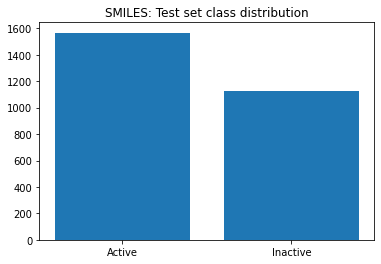

In [ ]:
count = [len(np.where(np.array(sm_y_test)==1)[0]), len(np.where(np.array(sm_y_test)==0)[0])]

plt.figure()
plt.bar(['Active', 'Inactive'], count)
plt.title('SMILES: Test set class distribution')
plt.show()

######SELFIES

In [ ]:
# hyperparameters
SPLIT = 10

HIDDEN = 256
N_LAYERS = 4
DROPOUT = 0.6
PAD_IDX = 0

BATCH = 256 # each dataset has 13,456 datapoints
LR = 5e-4
DECAY = 1e-5
WARMUP_STEPS = 200
EPOCHS = 30


splitter = KFold(n_splits=SPLIT, shuffle=True, random_state=0)
collate = functools.partial(collate_fn, pad_index=PAD_IDX)

# dataloader
sf_x_train, sf_x_test, sf_y_train, sf_y_test = train_test_split(cleaned_selfies, labels, test_size=0.2, shuffle=True, random_state=0)

train_dataset = Dataset(sf_x_train, sf_y_train, selfies_vocab)
test_dataset = Dataset(sf_x_test, sf_y_test, selfies_vocab)
train_loader = DataLoader(train_dataset, batch_size=BATCH, collate_fn=collate, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH, collate_fn=collate)

# model
model = GRU(len(selfies_vocab), 
            hidden_dim=HIDDEN, 
            output_dim=2, 
            n_layers=N_LAYERS, 
            dropout_rate=DROPOUT,
            bidirectional=True).to(device)
criterion = nn.CrossEntropyLoss().to(device)
optimizer = optim.Adam(model.parameters(), lr=LR, weight_decay=DECAY, eps=1e-6)
scheduler = ConstantWithWarmup(optimizer, WARMUP_STEPS)

# training
for e in range(EPOCHS):
  sf_train_accs, sf_train_losses, sf_train_predictions = training(model, train_loader, criterion, optimizer, scheduler, device)
  sf_train_acc = np.mean(sf_train_accs)
  sf_train_loss = np.mean(sf_train_losses)
  print(f'Epoch {e+1}')
  print(f'Training loss: {round(sf_train_loss, 4)}, Training acc: {round(sf_train_acc, 4)}\n')

Training...: 100%|██████████| 43/43 [00:11<00:00,  3.60it/s]


Epoch 1
Training loss: 0.6925, Training acc: 0.5604



Training...: 100%|██████████| 43/43 [00:12<00:00,  3.56it/s]


Epoch 2
Training loss: 0.6822, Training acc: 0.5827



Training...: 100%|██████████| 43/43 [00:12<00:00,  3.54it/s]


Epoch 3
Training loss: 0.6814, Training acc: 0.5776



Training...: 100%|██████████| 43/43 [00:12<00:00,  3.58it/s]


Epoch 4
Training loss: 0.6809, Training acc: 0.5823



Training...: 100%|██████████| 43/43 [00:11<00:00,  3.59it/s]


Epoch 5
Training loss: 0.6782, Training acc: 0.5881



Training...: 100%|██████████| 43/43 [00:11<00:00,  3.62it/s]


Epoch 6
Training loss: 0.6711, Training acc: 0.599



Training...: 100%|██████████| 43/43 [00:11<00:00,  3.60it/s]


Epoch 7
Training loss: 0.6543, Training acc: 0.627



Training...: 100%|██████████| 43/43 [00:11<00:00,  3.60it/s]


Epoch 8
Training loss: 0.6356, Training acc: 0.6485



Training...: 100%|██████████| 43/43 [00:11<00:00,  3.58it/s]


Epoch 9
Training loss: 0.6275, Training acc: 0.6511



Training...: 100%|██████████| 43/43 [00:11<00:00,  3.59it/s]


Epoch 10
Training loss: 0.6142, Training acc: 0.6668



Training...: 100%|██████████| 43/43 [00:11<00:00,  3.59it/s]


Epoch 11
Training loss: 0.6087, Training acc: 0.6746



Training...: 100%|██████████| 43/43 [00:11<00:00,  3.59it/s]


Epoch 12
Training loss: 0.592, Training acc: 0.686



Training...: 100%|██████████| 43/43 [00:11<00:00,  3.59it/s]


Epoch 13
Training loss: 0.5846, Training acc: 0.6944



Training...: 100%|██████████| 43/43 [00:11<00:00,  3.60it/s]


Epoch 14
Training loss: 0.5755, Training acc: 0.7003



Training...: 100%|██████████| 43/43 [00:11<00:00,  3.59it/s]


Epoch 15
Training loss: 0.5666, Training acc: 0.7088



Training...: 100%|██████████| 43/43 [00:11<00:00,  3.59it/s]


Epoch 16
Training loss: 0.558, Training acc: 0.7169



Training...: 100%|██████████| 43/43 [00:11<00:00,  3.59it/s]


Epoch 17
Training loss: 0.5449, Training acc: 0.7247



Training...: 100%|██████████| 43/43 [00:11<00:00,  3.59it/s]


Epoch 18
Training loss: 0.5306, Training acc: 0.7356



Training...: 100%|██████████| 43/43 [00:11<00:00,  3.59it/s]


Epoch 19
Training loss: 0.5243, Training acc: 0.7371



Training...: 100%|██████████| 43/43 [00:11<00:00,  3.59it/s]


Epoch 20
Training loss: 0.5086, Training acc: 0.7551



Training...: 100%|██████████| 43/43 [00:11<00:00,  3.58it/s]


Epoch 21
Training loss: 0.4972, Training acc: 0.7576



Training...: 100%|██████████| 43/43 [00:11<00:00,  3.59it/s]


Epoch 22
Training loss: 0.4855, Training acc: 0.7686



Training...: 100%|██████████| 43/43 [00:11<00:00,  3.59it/s]


Epoch 23
Training loss: 0.4812, Training acc: 0.7712



Training...: 100%|██████████| 43/43 [00:11<00:00,  3.59it/s]


Epoch 24
Training loss: 0.4787, Training acc: 0.7693



Training...: 100%|██████████| 43/43 [00:11<00:00,  3.59it/s]


Epoch 25
Training loss: 0.4587, Training acc: 0.7879



Training...: 100%|██████████| 43/43 [00:11<00:00,  3.59it/s]


Epoch 26
Training loss: 0.4429, Training acc: 0.7979



Training...: 100%|██████████| 43/43 [00:11<00:00,  3.59it/s]


Epoch 27
Training loss: 0.4292, Training acc: 0.8033



Training...: 100%|██████████| 43/43 [00:11<00:00,  3.59it/s]


Epoch 28
Training loss: 0.4271, Training acc: 0.8048



Training...: 100%|██████████| 43/43 [00:11<00:00,  3.59it/s]


Epoch 29
Training loss: 0.4303, Training acc: 0.8021



Training...: 100%|██████████| 43/43 [00:11<00:00,  3.59it/s]

Epoch 30
Training loss: 0.4293, Training acc: 0.8043



In [ ]:
sf_test_accs, sf_test_losses, sf_test_predictions = evaluate(model, test_loader, criterion, device)
sf_test_acc = np.mean(sf_test_accs)
sf_test_loss = np.mean(sf_test_losses)
print(f'Test loss: {round(sf_test_loss, 4)}, Test acc: {round(sf_test_acc, 4)}')

Evaluating...: 100%|██████████| 11/11 [00:00<00:00, 13.76it/s]

Test loss: 0.6798, Test acc: 0.691


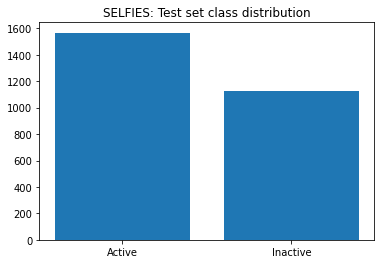

In [ ]:
count = [len(np.where(np.array(sf_y_test)==1)[0]), len(np.where(np.array(sf_y_test)==0)[0])]

plt.figure()
plt.bar(['Active', 'Inactive'], count)
plt.title('SELFIES: Test set class distribution')
plt.show()

####Result visualization

######SMILES for cross validation

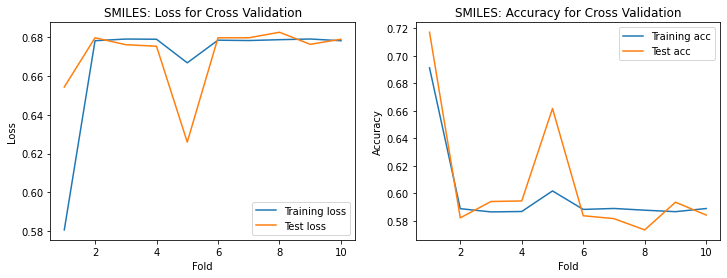

In [ ]:
train_accs, train_losses, test_accs, test_losses = [], [], [], []
for history in smiles_history:
  train_accs.append(history['train_acc'])
  train_losses.append(history['train_loss'])
  test_accs.append(history['test_acc'])
  test_losses.append(history['test_loss'])

plt.figure(figsize=[12, 4])
plt.subplot(121)
plt.plot(np.arange(1, 11), train_losses, label='Training loss')
plt.plot(np.arange(1, 11), test_losses, label='Test loss')
plt.xlabel('Fold'); plt.ylabel('Loss')
plt.title('SMILES: Loss for Cross Validation')
plt.legend()

plt.subplot(122)
plt.plot(np.arange(1, 11), train_accs, label='Training acc')
plt.plot(np.arange(1, 11), test_accs, label='Test acc')
plt.xlabel('Fold'); plt.ylabel('Accuracy')
plt.title('SMILES: Accuracy for Cross Validation')
plt.legend()
plt.show()

######SELFIES for cross validation

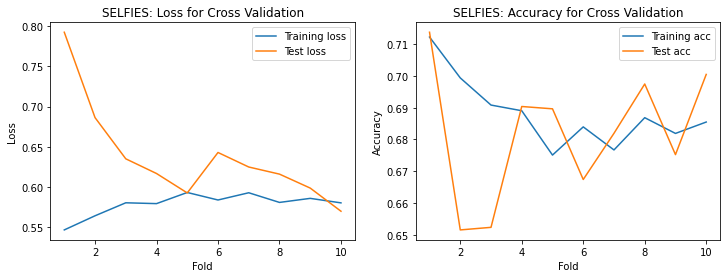

In [ ]:
train_accs, train_losses, test_accs, test_losses = [], [], [], []
for history in selfies_history:
  train_accs.append(history['train_acc'])
  train_losses.append(history['train_loss'])
  test_accs.append(history['test_acc'])
  test_losses.append(history['test_loss'])

plt.figure(figsize=[12, 4])
plt.subplot(121)
plt.plot(np.arange(1, 11), train_losses, label='Training loss')
plt.plot(np.arange(1, 11), test_losses, label='Test loss')
plt.xlabel('Fold'); plt.ylabel('Loss')
plt.title('SELFIES: Loss for Cross Validation')
plt.legend()

plt.subplot(122)
plt.plot(np.arange(1, 11), train_accs, label='Training acc')
plt.plot(np.arange(1, 11), test_accs, label='Test acc')
plt.xlabel('Fold'); plt.ylabel('Accuracy')
plt.title('SELFIES: Accuracy for Cross Validation')
plt.legend()
plt.show()

#Evaluation metrics

Confusion matrix, precision, recall, ROC curve, AUCROC score

#####SMILES result

In [ ]:
sm_y_preds = [0 if p[0] > p[1] else 1 for pred in sm_test_predictions for p in pred]

sm_balanced_acc = balanced_accuracy_score(sm_y_test, sm_y_preds)
sm_MCC = matthews_corrcoef(sm_y_test, sm_y_preds)
sm_precision = precision_score(sm_y_test, sm_y_preds)
sm_recall = recall_score(sm_y_test, sm_y_preds)
sm_f1 = f1_score(sm_y_test, sm_y_preds)
sm_aucroc = roc_auc_score(sm_y_test, sm_y_preds)
sm_MCC = matthews_corrcoef(sm_y_test, sm_y_preds)

#####SELFIES result

In [ ]:
sf_y_preds = [0 if p[0] > p[1] else 1 for pred in sf_test_predictions for p in pred]

sf_balanced_acc = balanced_accuracy_score(sf_y_test, sf_y_preds)
sf_MCC = matthews_corrcoef(sf_y_test, sf_y_preds)
sf_precision = precision_score(sf_y_test, sf_y_preds)
sf_recall = recall_score(sf_y_test, sf_y_preds)
sf_f1 = f1_score(sf_y_test, sf_y_preds)
sf_aucroc = roc_auc_score(sf_y_test, sf_y_preds)
sf_MCC = matthews_corrcoef(sf_y_test, sf_y_preds)

In [ ]:
result = pd.DataFrame({'Data': ['SMILES', 'SELFIES'],
                       'Accuracy': [sm_test_acc, sf_test_acc],
                       'Balanced accuracy': [sm_balanced_acc, sf_balanced_acc],
                       'Precision': [sm_precision, sf_precision],
                       'Recall': [sm_recall, sf_recall],
                       'F1 score': [sm_f1, sf_f1],
                       'AUCROC': [sm_aucroc, sf_aucroc],
                       'Matthew coeff': [sm_MCC, sf_MCC]})
result

,Data,Accuracy,Balanced accuracy,Precision,Recall,F1 score,AUCROC,Matthew coeff
0,SMILES,0.582483,0.500000,0.582095,1.000000,0.735853,0.500000,0.000000
1,SELFIES,0.691019,0.678088,0.721097,0.772176,0.745763,0.678088,0.362544
